# Artist Collaboration Graph

The objective of this file is to extract relevant insights from the spotify dataset, organized as a graph, where the nodes are artists and the edges are collaborations between them (including features, such as th popularity of the song, the duration, etc.). The plan is to extract, for example, the following insights:
- Genre Detection: Identify clusters.
- Most collaborative artists: Using Degree Centrality.
- Bridge artists between genres: Using Betweenness Centrality.

## Load the dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("maharshipandya/-spotify-tracks-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/joaolopes2003/.cache/kagglehub/datasets/maharshipandya/-spotify-tracks-dataset/versions/1


In [3]:
import pandas as pd
import os

# Assuming KaggleHub gives you the CSV path in 'path'
file_path = os.path.join(path, "dataset.csv")  # Adjust if the filename differs
df = pd.read_csv(file_path)

# Show the first few rows
print(df.columns)

Index(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre'],
      dtype='object')


In [4]:
df.head(3)

Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   

         album_name        track_name  popularity  duration_ms  explicit  \
0            Comedy            Comedy          73       230666     False   
1  Ghost (Acoustic)  Ghost - Acoustic          55       149610     False   
2    To Begin Again    To Begin Again          57       210826     False   

   danceability  energy  ...  loudness  mode  speechiness  acousticness  \
0         0.676   0.461  ...    -6.746     0       0.1430        0.0322   
1         0.420   0.166  ...   -17.235     1       0.0763        0.9240   
2         0.438   0.359  ...    -9.734     1       0.0557        0.2100   

   instrumentalness  liveness  valence   tempo  time_signature  track_genre  
0          0.000001     0.358    0.715  87.917               4     acoustic  
1          0.000006     0.101    0.267  77.489               4     acoustic  
2          0.000000     0.117    0.120  76.332               4     acoustic  

[3 rows x 21 columns]

## Data Preprocessing

In [5]:
# Filter songs with no artists
df = df[df['artists'].notna() & (df['artists'] != '')]

# Convert semicolon-separated artist strings into Python lists
df['artists'] = df['artists'].apply(lambda x: [artist.strip() for artist in x.split(';') if artist.strip()])

In [6]:
df.head(3)

Unnamed: 0                track_id                    artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV              [Gen Hoshino]   
1           1  4qPNDBW1i3p13qLCt0Ki3A             [Ben Woodward]   
2           2  1iJBSr7s7jYXzM8EGcbK5b  [Ingrid Michaelson, ZAYN]   

         album_name        track_name  popularity  duration_ms  explicit  \
0            Comedy            Comedy          73       230666     False   
1  Ghost (Acoustic)  Ghost - Acoustic          55       149610     False   
2    To Begin Again    To Begin Again          57       210826     False   

   danceability  energy  ...  loudness  mode  speechiness  acousticness  \
0         0.676   0.461  ...    -6.746     0       0.1430        0.0322   
1         0.420   0.166  ...   -17.235     1       0.0763        0.9240   
2         0.438   0.359  ...    -9.734     1       0.0557        0.2100   

   instrumentalness  liveness  valence   tempo  time_signature  track_genre  
0          0.000001     0.358    0.715  87.917               4     acoustic  
1          0.000006     0.101    0.267  77.489               4     acoustic  
2          0.000000     0.117    0.120  76.332               4     acoustic  

[3 rows x 21 columns]

## Creating the Graph

In [9]:
import networkx as nx

# Initialize MultiGraph (undirected graph with multiple edges allowed)
G = nx.MultiGraph()

for _, row in df.iterrows():
    artists = row['artists']
    
    # Get song metadata
    popularity = row.get('popularity', 0)
    song_info = {
        'track_name': row.get('track_name'),
        'album_name': row.get('album_name'),
        'duration_ms': row.get('duration_ms'),
        'genre': row.get('track_genre', 'Unknown'),  # Assuming there's a genre column
        'popularity': popularity,
        'weight': popularity  # 💡 this is the edge weight
    }

    if len(artists) > 1:
        # Add one edge per artist pair (for each song)
        for i in range(len(artists)):
            for j in range(i + 1, len(artists)):
                G.add_edge(artists[i], artists[j], **song_info)
    else:
        # Solo song → self-loop
        artist = artists[0]
        G.add_edge(artist, artist, **song_info)

## Graph Analysis

### Basic Insights - Complete Graph

In [10]:
print("Number of artists:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Total number of songs:", len(df))
print("Number of solo songs:", sum(1 for u, v in G.edges() if u == v))

# Number of solo and collaborative artists
solo = sum(1 for node in G.nodes if G.has_edge(node, node))
collab = G.number_of_nodes() - solo
print(f"Solo artists: {solo}, Collaborating artists: {collab}")

Number of artists: 29858
Number of edges: 157180
Total number of songs: 113999
Number of solo songs: 83924
Solo artists: 15038, Collaborating artists: 14820


/home/joaolopes2003/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


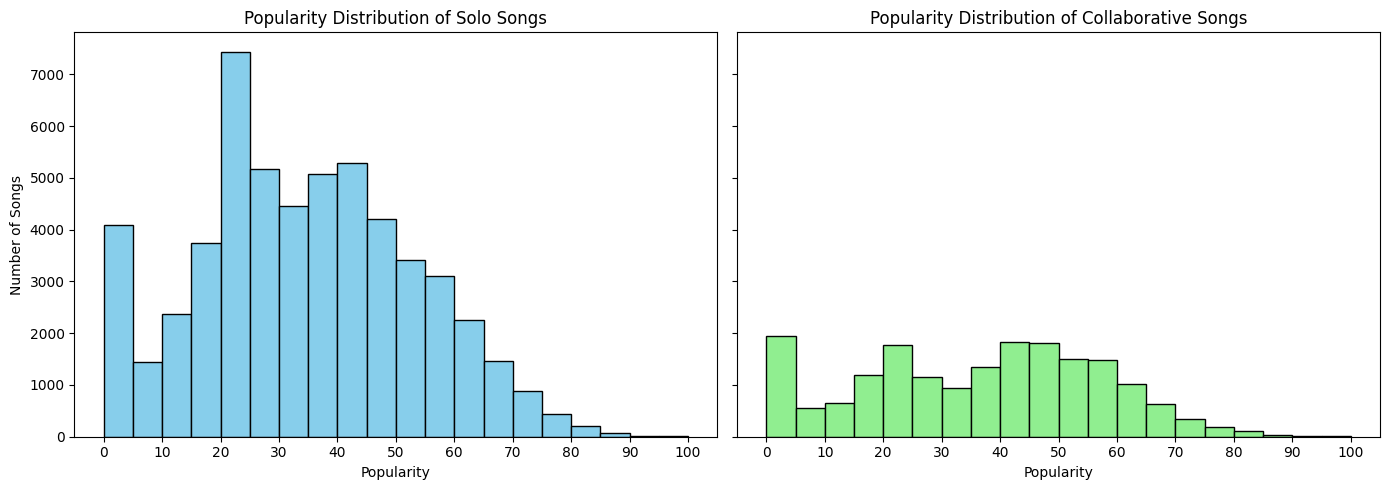

In [11]:
import matplotlib.pyplot as plt

solo_popularity = []
collab_popularity = []

# Track seen songs by their unique name
seen_tracks = set()

for u, v, data in G.edges(data=True):
    track_name = data.get('track_name')
    popularity = data.get('popularity', 0)

    # Skip if we've already counted this track
    if track_name in seen_tracks:
        continue
    seen_tracks.add(track_name)

    if u == v:
        solo_popularity.append(popularity)
    else:
        collab_popularity.append(popularity)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

axes[0].hist(solo_popularity, bins=range(0, 105, 5), color='skyblue', edgecolor='black')
axes[0].set_title('Popularity Distribution of Solo Songs')
axes[0].set_xlabel('Popularity')
axes[0].set_ylabel('Number of Songs')
axes[0].set_xticks(range(0, 101, 10))

axes[1].hist(collab_popularity, bins=range(0, 105, 5), color='lightgreen', edgecolor='black')
axes[1].set_title('Popularity Distribution of Collaborative Songs')
axes[1].set_xlabel('Popularity')
axes[1].set_xticks(range(0, 101, 10))

plt.tight_layout()
plt.show()

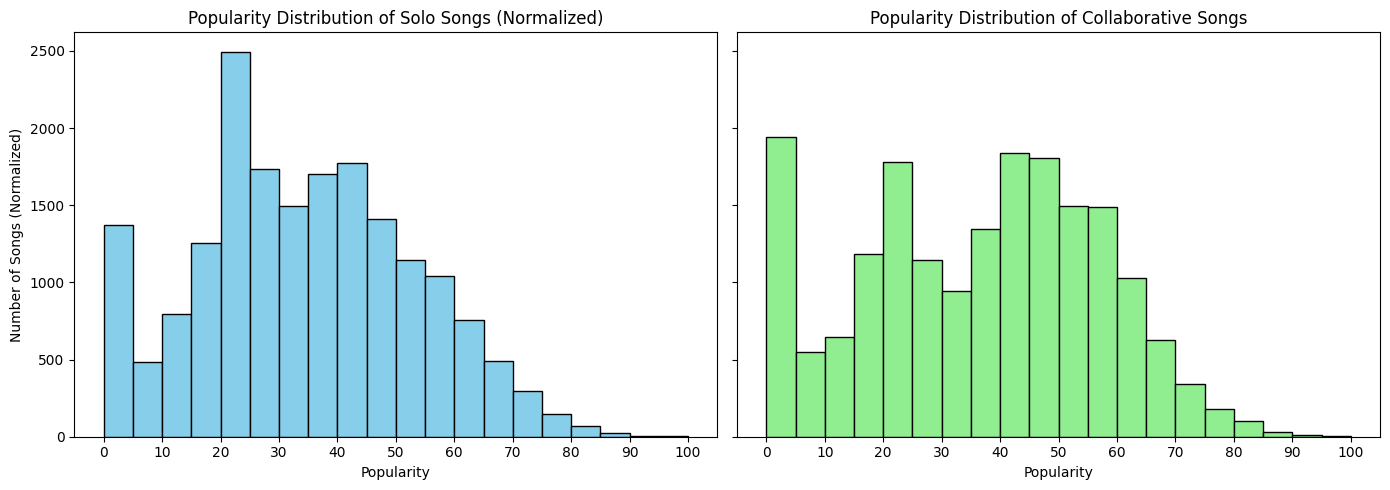

In [10]:
import matplotlib.pyplot as plt
import numpy as np

solo_popularity = []
collab_popularity = []

seen_tracks = set()

for u, v, data in G.edges(data=True):
    track_name = data.get('track_name')
    popularity = data.get('popularity', 0)

    if track_name in seen_tracks:
        continue
    seen_tracks.add(track_name)

    if u == v:
        solo_popularity.append(popularity)
    else:
        collab_popularity.append(popularity)

# Calculate normalization factor
num_solo = len(solo_popularity)
num_collab = len(collab_popularity)
normalization_factor = num_solo / num_collab if num_collab != 0 else 1

# Define bins
bins = range(0, 105, 5)

# Calculate histograms
solo_counts, _ = np.histogram(solo_popularity, bins=bins)
collab_counts, _ = np.histogram(collab_popularity, bins=bins)

# Normalize solo counts
solo_counts_normalized = solo_counts / normalization_factor

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

axes[0].bar(bins[:-1], solo_counts_normalized, width=5, color='skyblue', edgecolor='black', align='edge')
axes[0].set_title('Popularity Distribution of Solo Songs (Normalized)')
axes[0].set_xlabel('Popularity')
axes[0].set_ylabel('Number of Songs (Normalized)')
axes[0].set_xticks(range(0, 101, 10))

axes[1].bar(bins[:-1], collab_counts, width=5, color='lightgreen', edgecolor='black', align='edge')
axes[1].set_title('Popularity Distribution of Collaborative Songs')
axes[1].set_xlabel('Popularity')
axes[1].set_xticks(range(0, 101, 10))

plt.tight_layout()
plt.show()

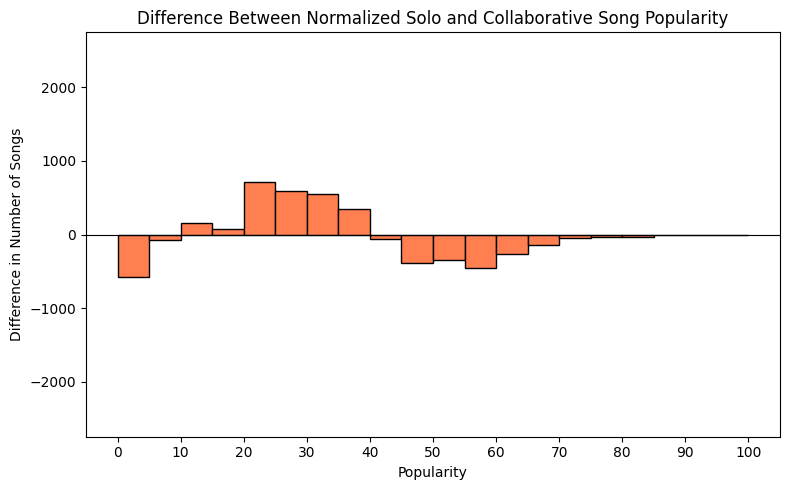

In [11]:
import matplotlib.pyplot as plt
import numpy as np

solo_popularity = []
collab_popularity = []

seen_tracks = set()

for u, v, data in G.edges(data=True):
    track_name = data.get('track_name')
    popularity = data.get('popularity', 0)

    if track_name in seen_tracks:
        continue
    seen_tracks.add(track_name)

    if u == v:
        solo_popularity.append(popularity)
    else:
        collab_popularity.append(popularity)

# Calculate normalization factor
num_solo = len(solo_popularity)
num_collab = len(collab_popularity)
normalization_factor = num_solo / num_collab if num_collab != 0 else 1

# Define bins
bins = range(0, 105, 5)

# Calculate histograms
solo_counts, _ = np.histogram(solo_popularity, bins=bins)
collab_counts, _ = np.histogram(collab_popularity, bins=bins)

# Normalize solo counts
solo_counts_normalized = solo_counts / normalization_factor

# Calculate difference
difference = solo_counts_normalized - collab_counts

# Determine y-axis limits based on previous plots
max_count = max(solo_counts_normalized.max(), collab_counts.max())
y_lim_upper = max_count * 1.1  # Add 10% padding
y_lim_lower = -y_lim_upper     # Symmetric lower bound for differences

# Plotting the difference
plt.figure(figsize=(8,5))
plt.bar(bins[:-1], difference, width=5, color='coral', edgecolor='black', align='edge')
plt.title('Difference Between Normalized Solo and Collaborative Song Popularity')
plt.xlabel('Popularity')
plt.ylabel('Difference in Number of Songs')
plt.xticks(range(0, 101, 10))
plt.axhline(0, color='black', linewidth=0.8)
plt.ylim(y_lim_lower, y_lim_upper)
plt.tight_layout()
plt.show()

In [12]:
import networkx as nx
from collections import Counter

# Get all connected components
components = nx.connected_components(G)

# Count the size of each component
component_sizes = [len(c) for c in components]

# Count how many components have each size
size_counts = Counter(component_sizes)

# Display results
print("Number of components per size:")
for size, count in sorted(size_counts.items()):
    print(f"Size {size}: {count} components")

Number of components per size:
Size 1: 10160 components
Size 2: 1453 components
Size 3: 448 components
Size 4: 178 components
Size 5: 94 components
Size 6: 58 components
Size 7: 33 components
Size 8: 28 components
Size 9: 18 components
Size 10: 12 components
Size 11: 8 components
Size 12: 11 components
Size 13: 2 components
Size 14: 5 components
Size 15: 4 components
Size 16: 2 components
Size 17: 2 components
Size 18: 2 components
Size 20: 1 components
Size 26: 1 components
Size 54: 1 components
Size 59: 1 components
Size 99: 1 components
Size 178: 1 components
Size 12267: 1 components


In [13]:
import networkx as nx
from collections import defaultdict

# Get all connected components
components = list(nx.connected_components(G))

# Dictionary: key = component size, value = list of avg popularities per component
popularity_by_component_size = defaultdict(list)

# For each component
for component in components:
    subgraph = G.subgraph(component)
    total_popularity = 0
    num_tracks = 0
    seen_tracks = set()
    
    # Iterate over edges to gather popularity of tracks (each track is a unique edge)
    for u, v, data in subgraph.edges(data=True):
        track_name = data.get('track_name')
        if track_name in seen_tracks:
            continue
        seen_tracks.add(track_name)
        
        popularity = data.get('popularity', 0)
        total_popularity += popularity
        num_tracks += 1
    
    # Skip components with no associated tracks
    if num_tracks == 0:
        continue

    avg_pop = total_popularity / num_tracks
    popularity_by_component_size[len(component)].append(avg_pop)

# Calculate average popularity per component size group
print("Average popularity per component size:")
for size in sorted(popularity_by_component_size.keys()):
    avg = sum(popularity_by_component_size[size]) / len(popularity_by_component_size[size])
    print(f"Component size {size}: Average popularity = {avg:.2f} based on {len(popularity_by_component_size[size])} components")


Average popularity per component size:
Component size 1: Average popularity = 35.79 based on 10160 components
Component size 2: Average popularity = 36.07 based on 1453 components
Component size 3: Average popularity = 35.30 based on 448 components
Component size 4: Average popularity = 33.02 based on 178 components
Component size 5: Average popularity = 33.91 based on 94 components
Component size 6: Average popularity = 30.44 based on 58 components
Component size 7: Average popularity = 30.16 based on 33 components
Component size 8: Average popularity = 34.24 based on 28 components
Component size 9: Average popularity = 31.44 based on 18 components
Component size 10: Average popularity = 29.63 based on 12 components
Component size 11: Average popularity = 28.29 based on 8 components
Component size 12: Average popularity = 30.60 based on 11 components
Component size 13: Average popularity = 33.04 based on 2 components
Component size 14: Average popularity = 29.60 based on 5 components


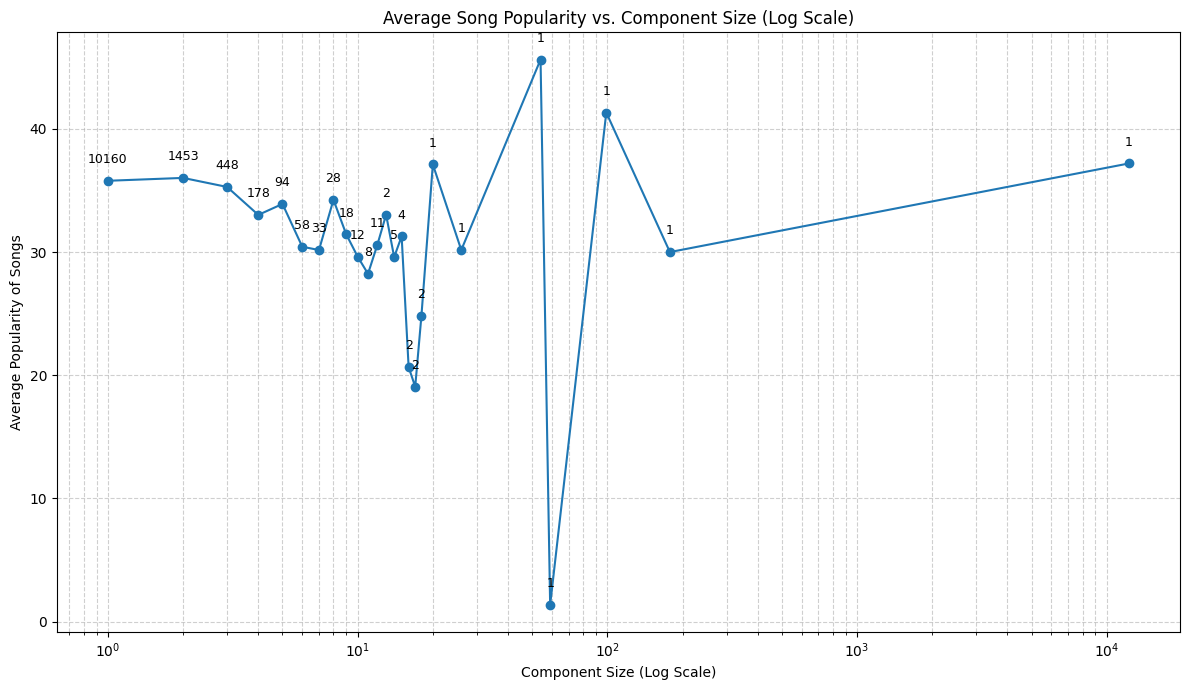

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
component_sizes = sorted(popularity_by_component_size.keys())
average_popularities = [
    sum(popularity_by_component_size[size]) / len(popularity_by_component_size[size])
    for size in component_sizes
]
component_counts = [
    len(popularity_by_component_size[size])
    for size in component_sizes
]

# Plot
plt.figure(figsize=(12, 7))
plt.plot(component_sizes, average_popularities, marker='o', linestyle='-')
plt.title("Average Song Popularity vs. Component Size (Log Scale)")
plt.xlabel("Component Size (Log Scale)")
plt.ylabel("Average Popularity of Songs")
plt.xscale('log')
plt.grid(True, which='both', linestyle='--', alpha=0.6)

# Annotate each point with the number of components
for x, y, count in zip(component_sizes, average_popularities, component_counts):
    plt.text(x, y + 1.2, str(count), fontsize=9, ha='center', va='bottom')

plt.tight_layout()
plt.show()

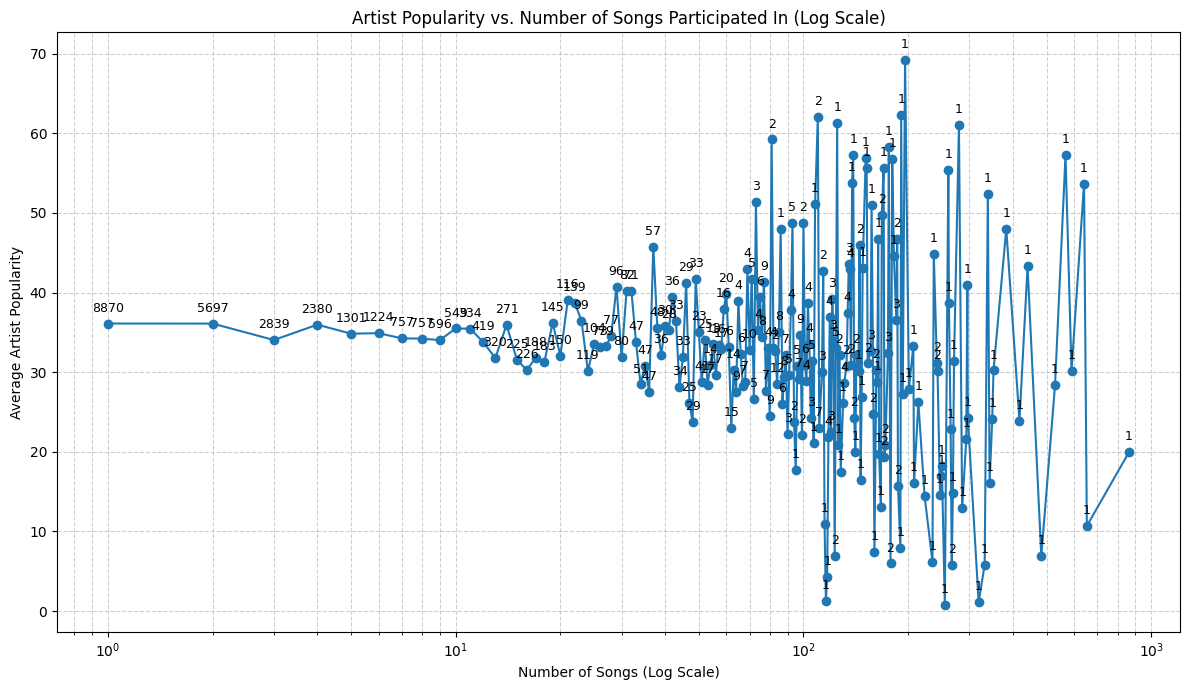

In [20]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

# Dictionary: artist -> list of song popularities
artist_song_popularities = defaultdict(list)

# Fill the dictionary from the graph
for u, v, data in G.edges(data=True):
    popularity = data.get('popularity', 0)
    
    if u == v:
        artist_song_popularities[u].append(popularity)
    else:
        artist_song_popularities[u].append(popularity)
        artist_song_popularities[v].append(popularity)

# Dictionary: num_songs -> list of average popularities
songs_vs_popularity = defaultdict(list)
artist_counts = defaultdict(int)

for artist, pops in artist_song_popularities.items():
    num_songs = len(pops)
    avg_pop = sum(pops) / num_songs if num_songs > 0 else 0
    songs_vs_popularity[num_songs].append(avg_pop)
    artist_counts[num_songs] += 1

# Prepare data for plotting
x_vals = sorted(songs_vs_popularity.keys())
y_vals = [sum(songs_vs_popularity[k]) / len(songs_vs_popularity[k]) for k in x_vals]
count_labels = [artist_counts[k] for k in x_vals]

# Plot
plt.figure(figsize=(12, 7))
plt.plot(x_vals, y_vals, marker='o', linestyle='-')
plt.xscale('log')
plt.xlabel("Number of Songs (Log Scale)")
plt.ylabel("Average Artist Popularity")
plt.title("Artist Popularity vs. Number of Songs Participated In (Log Scale)")
plt.grid(True, which='both', linestyle='--', alpha=0.6)

# Annotate number of artists per point
for x, y, count in zip(x_vals, y_vals, count_labels):
    plt.text(x, y + 1.5, str(count), fontsize=9, ha='center')

plt.tight_layout()
plt.show()

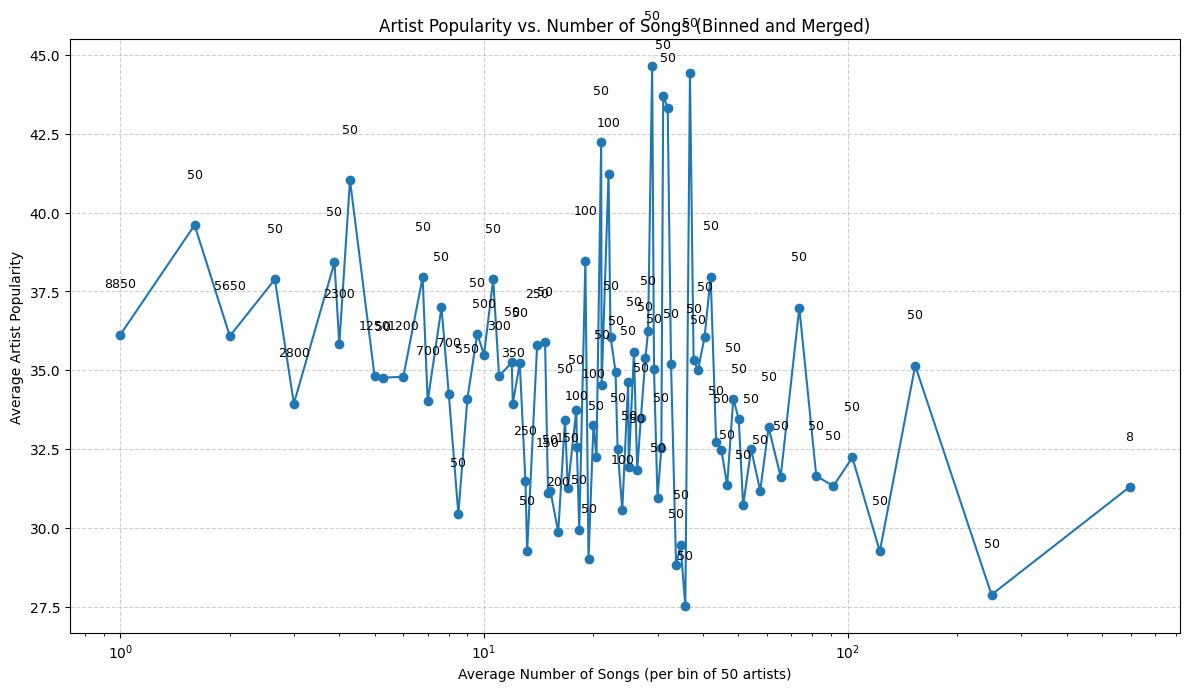

In [27]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

# Step 1: Build dictionary of artist -> list of song popularities
artist_song_popularities = defaultdict(list)

for u, v, data in G.edges(data=True):
    popularity = data.get('popularity', 0)
    if u == v:
        artist_song_popularities[u].append(popularity)
    else:
        artist_song_popularities[u].append(popularity)
        artist_song_popularities[v].append(popularity)

# Step 2: List of (num_songs, avg_popularity) for each artist
artist_stats = []
for artist, pops in artist_song_popularities.items():
    num_songs = len(pops)
    avg_pop = sum(pops) / num_songs if num_songs > 0 else 0
    artist_stats.append((num_songs, avg_pop))

# Step 3: Sort by number of songs
artist_stats.sort(key=lambda x: x[0])

# Step 4: Group every 10 artists into bins
bin_size = 50
raw_bins = []

i = 0
while i < len(artist_stats):
    bin_group = artist_stats[i:i + bin_size]
    if not bin_group:
        break
    song_counts = [entry[0] for entry in bin_group]
    pop_values = [entry[1] for entry in bin_group]
    avg_num_songs = sum(song_counts) / len(song_counts)
    avg_popularity = sum(pop_values) / len(pop_values)

    raw_bins.append((avg_num_songs, avg_popularity, len(bin_group)))
    i += bin_size

# Step 5: Merge bins with same avg_num_songs
from collections import defaultdict

merged_bins = defaultdict(lambda: {"pop_sum": 0.0, "count": 0, "num_artists": 0})

for x, y, count in raw_bins:
    merged_bins[x]["pop_sum"] += y * count
    merged_bins[x]["count"] += count
    merged_bins[x]["num_artists"] += count

# Step 6: Prepare plot data
final_x = []
final_y = []
final_counts = []

for x in sorted(merged_bins):
    merged = merged_bins[x]
    final_x.append(x)
    final_y.append(merged["pop_sum"] / merged["count"])
    final_counts.append(merged["num_artists"])

# Step 7: Plot
plt.figure(figsize=(12, 7))
plt.plot(final_x, final_y, marker='o', linestyle='-')
plt.xscale('log')
plt.xlabel("Average Number of Songs (per bin of 50 artists)")
plt.ylabel("Average Artist Popularity")
plt.title("Artist Popularity vs. Number of Songs (Binned and Merged)")
plt.grid(True, linestyle='--', alpha=0.6)

# Annotate each point with number of artists
for x, y, count in zip(final_x, final_y, final_counts):
    plt.text(x, y + 1.5, str(count), fontsize=9, ha='center')

plt.tight_layout()
plt.show()

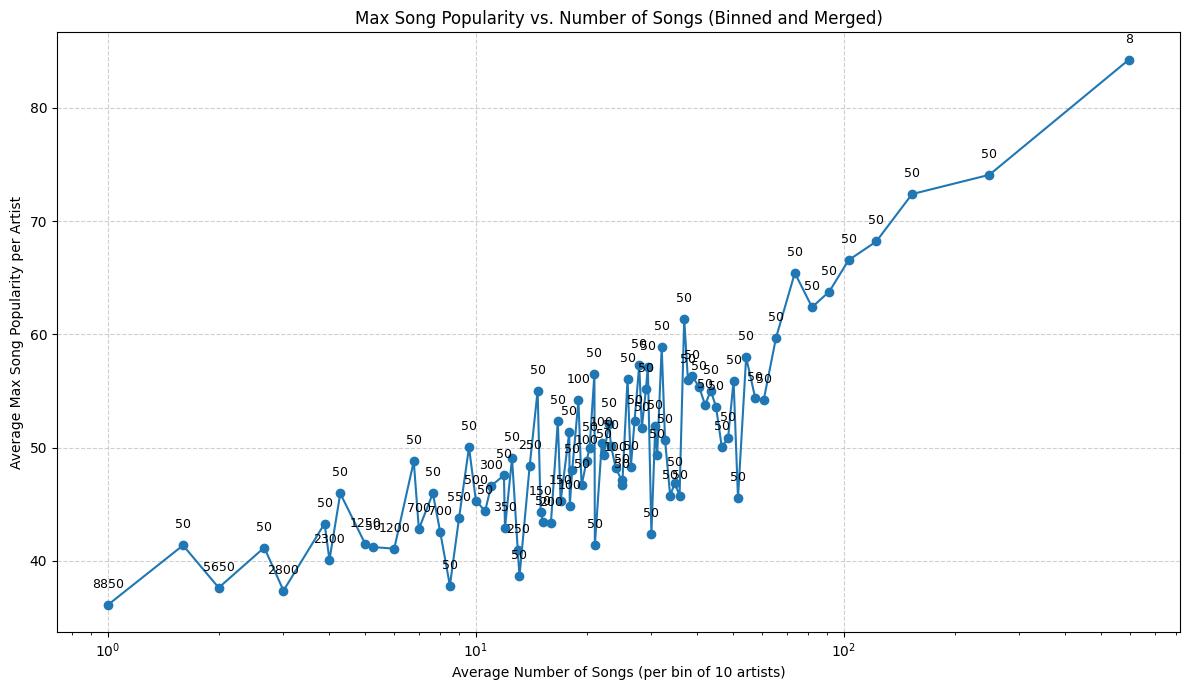

In [32]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

# Step 1: Build dictionary of artist -> list of song popularities
artist_song_popularities = defaultdict(list)

for u, v, data in G.edges(data=True):
    popularity = data.get('popularity', 0)
    if u == v:
        artist_song_popularities[u].append(popularity)
    else:
        artist_song_popularities[u].append(popularity)
        artist_song_popularities[v].append(popularity)

# Step 2: List of (num_songs, max_popularity) for each artist
artist_stats = []
for artist, pops in artist_song_popularities.items():
    num_songs = len(pops)
    max_pop = max(pops) if pops else 0
    artist_stats.append((num_songs, max_pop))

# Step 3: Sort by number of songs
artist_stats.sort(key=lambda x: x[0])

# Step 4: Group every 10 artists into bins
bin_size = 50
raw_bins = []

i = 0
while i < len(artist_stats):
    bin_group = artist_stats[i:i + bin_size]
    if not bin_group:
        break
    song_counts = [entry[0] for entry in bin_group]
    pop_values = [entry[1] for entry in bin_group]  # max popularity
    avg_num_songs = sum(song_counts) / len(song_counts)
    avg_max_popularity = sum(pop_values) / len(pop_values)

    raw_bins.append((avg_num_songs, avg_max_popularity, len(bin_group)))
    i += bin_size

# Step 5: Merge bins with same avg_num_songs
merged_bins = defaultdict(lambda: {"pop_sum": 0.0, "count": 0, "num_artists": 0})

for x, y, count in raw_bins:
    merged_bins[x]["pop_sum"] += y * count
    merged_bins[x]["count"] += count
    merged_bins[x]["num_artists"] += count

# Step 6: Prepare plot data
final_x = []
final_y = []
final_counts = []

for x in sorted(merged_bins):
    merged = merged_bins[x]
    final_x.append(x)
    final_y.append(merged["pop_sum"] / merged["count"])
    final_counts.append(merged["num_artists"])

# Step 7: Plot
plt.figure(figsize=(12, 7))
plt.plot(final_x, final_y, marker='o', linestyle='-')
plt.xscale('log')
plt.xlabel("Average Number of Songs (per bin of 10 artists)")
plt.ylabel("Average Max Song Popularity per Artist")
plt.title("Max Song Popularity vs. Number of Songs (Binned and Merged)")
plt.grid(True, linestyle='--', alpha=0.6)

# Annotate each point with number of artists
for x, y, count in zip(final_x, final_y, final_counts):
    plt.text(x, y + 1.5, str(count), fontsize=9, ha='center')

plt.tight_layout()
plt.show()

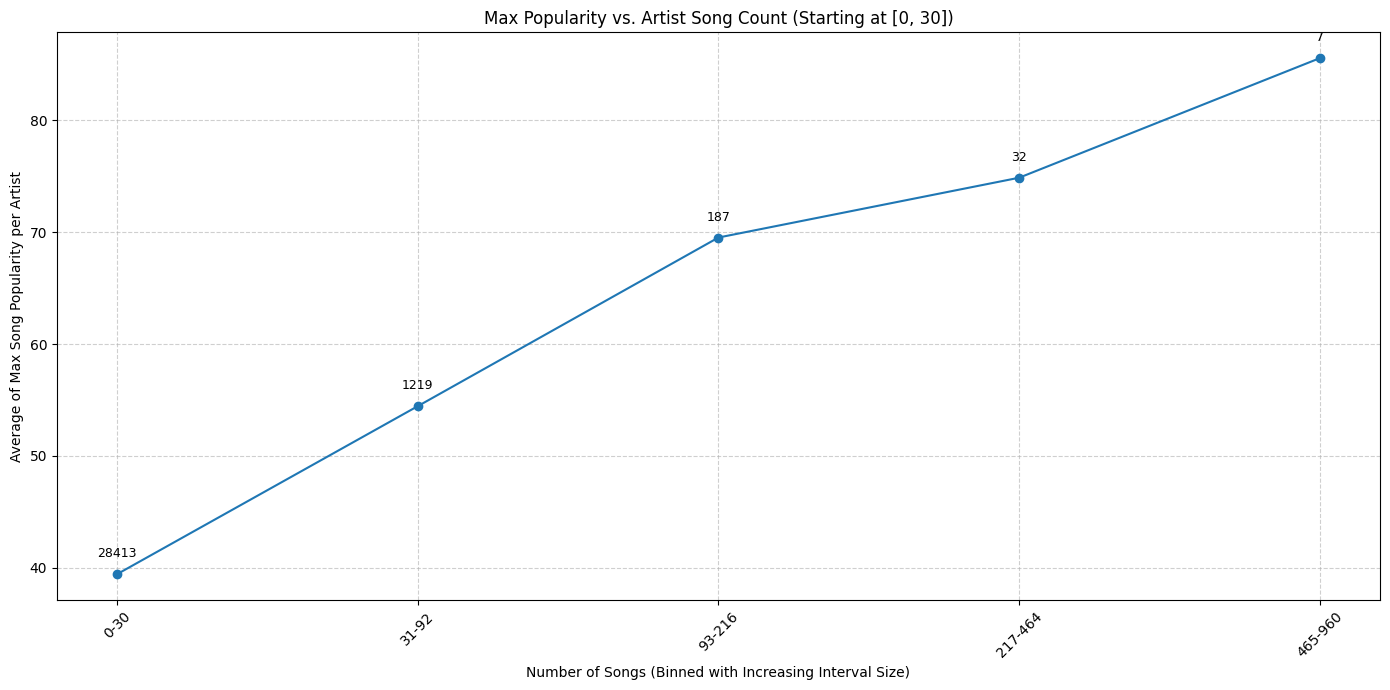

In [33]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

# Step 1: Build artist -> list of song popularities
artist_song_popularities = defaultdict(list)

for u, v, data in G.edges(data=True):
    popularity = data.get('popularity', 0)
    if u == v:
        artist_song_popularities[u].append(popularity)
    else:
        artist_song_popularities[u].append(popularity)
        artist_song_popularities[v].append(popularity)

# Step 2: Collect (num_songs, max_popularity) per artist
artist_stats = []
for artist, pops in artist_song_popularities.items():
    num_songs = len(pops)
    max_popularity = max(pops) if pops else 0
    artist_stats.append((num_songs, max_popularity))

# Step 3: Define custom binning starting with [0, 30], then doubling width
def generate_bins(start=0, initial_width=31, factor=2, max_val=500):
    bins = []
    width = initial_width
    current_start = start
    while current_start <= max_val:
        current_end = current_start + width - 1
        bins.append((current_start, current_end))
        current_start = current_end + 1
        width *= factor
    return bins

max_song_count = max(x[0] for x in artist_stats)
bins = generate_bins(max_val=max_song_count)

# Step 4: Assign artists to bins and compute average of max popularity
binned_data = defaultdict(list)

for num_songs, max_popularity in artist_stats:
    for b_start, b_end in bins:
        if b_start <= num_songs <= b_end:
            bin_label = f"{b_start}-{b_end}"
            binned_data[bin_label].append(max_popularity)
            break

# Step 5: Prepare plot data
x_labels = []
x_ticks = []
avg_max_popularities = []
counts = []

for idx, (label, values) in enumerate(binned_data.items()):
    x_labels.append(label)
    x_ticks.append(idx)
    avg_max_popularities.append(np.mean(values))
    counts.append(len(values))

# Step 6: Plot
plt.figure(figsize=(14, 7))
plt.plot(x_ticks, avg_max_popularities, marker='o', linestyle='-')
plt.xticks(x_ticks, x_labels, rotation=45)
plt.xlabel("Number of Songs (Binned with Increasing Interval Size)")
plt.ylabel("Average of Max Song Popularity per Artist")
plt.title("Max Popularity vs. Artist Song Count (Starting at [0, 30])")
plt.grid(True, linestyle='--', alpha=0.6)

# Annotate number of artists per bin
for x, y, count in zip(x_ticks, avg_max_popularities, counts):
    plt.text(x, y + 1.5, str(count), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

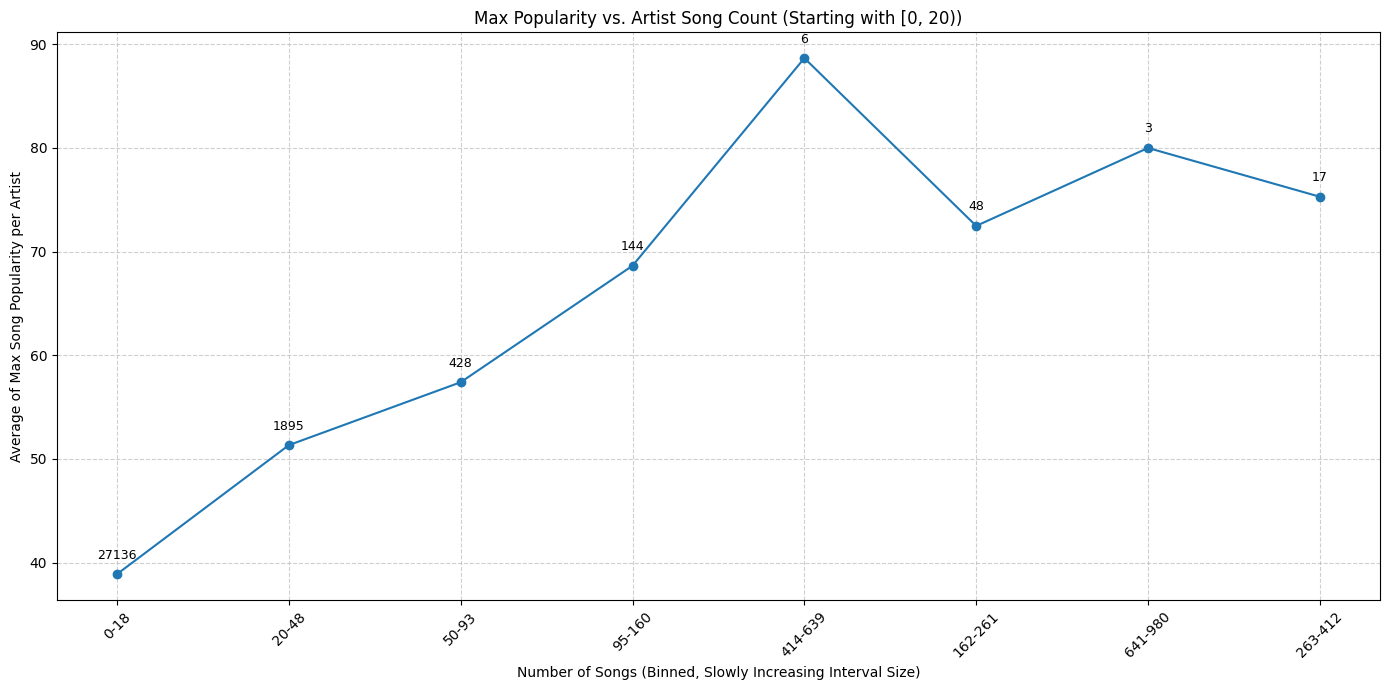

In [34]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

# Step 1: Build artist -> list of song popularities
artist_song_popularities = defaultdict(list)

for u, v, data in G.edges(data=True):
    popularity = data.get('popularity', 0)
    if u == v:
        artist_song_popularities[u].append(popularity)
    else:
        artist_song_popularities[u].append(popularity)
        artist_song_popularities[v].append(popularity)

# Step 2: Collect (num_songs, max_popularity) per artist
artist_stats = []
for artist, pops in artist_song_popularities.items():
    num_songs = len(pops)
    max_popularity = max(pops) if pops else 0
    artist_stats.append((num_songs, max_popularity))

# Step 3: Define custom binning: [0,20), then slowly increasing width
def generate_bins(start=0, initial_width=20, factor=1.5, max_val=500):
    bins = []
    width = initial_width
    current_start = start
    while current_start <= max_val:
        current_end = int(current_start + width)
        bins.append((current_start, current_end - 1))  # [start, end)
        current_start = current_end
        width *= factor
    return bins

max_song_count = max(x[0] for x in artist_stats)
bins = generate_bins(max_val=max_song_count)

# Step 4: Assign artists to bins and compute average of max popularity
binned_data = defaultdict(list)

for num_songs, max_popularity in artist_stats:
    for b_start, b_end in bins:
        if b_start <= num_songs < b_end:
            bin_label = f"{b_start}-{b_end - 1}"
            binned_data[bin_label].append(max_popularity)
            break

# Step 5: Prepare plot data
x_labels = []
x_ticks = []
avg_max_popularities = []
counts = []

for idx, (label, values) in enumerate(binned_data.items()):
    x_labels.append(label)
    x_ticks.append(idx)
    avg_max_popularities.append(np.mean(values))
    counts.append(len(values))

# Step 6: Plot
plt.figure(figsize=(14, 7))
plt.plot(x_ticks, avg_max_popularities, marker='o', linestyle='-')
plt.xticks(x_ticks, x_labels, rotation=45)
plt.xlabel("Number of Songs (Binned, Slowly Increasing Interval Size)")
plt.ylabel("Average of Max Song Popularity per Artist")
plt.title("Max Popularity vs. Artist Song Count (Starting with [0, 20))")
plt.grid(True, linestyle='--', alpha=0.6)

# Annotate number of artists per bin
for x, y, count in zip(x_ticks, avg_max_popularities, counts):
    plt.text(x, y + 1.5, str(count), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

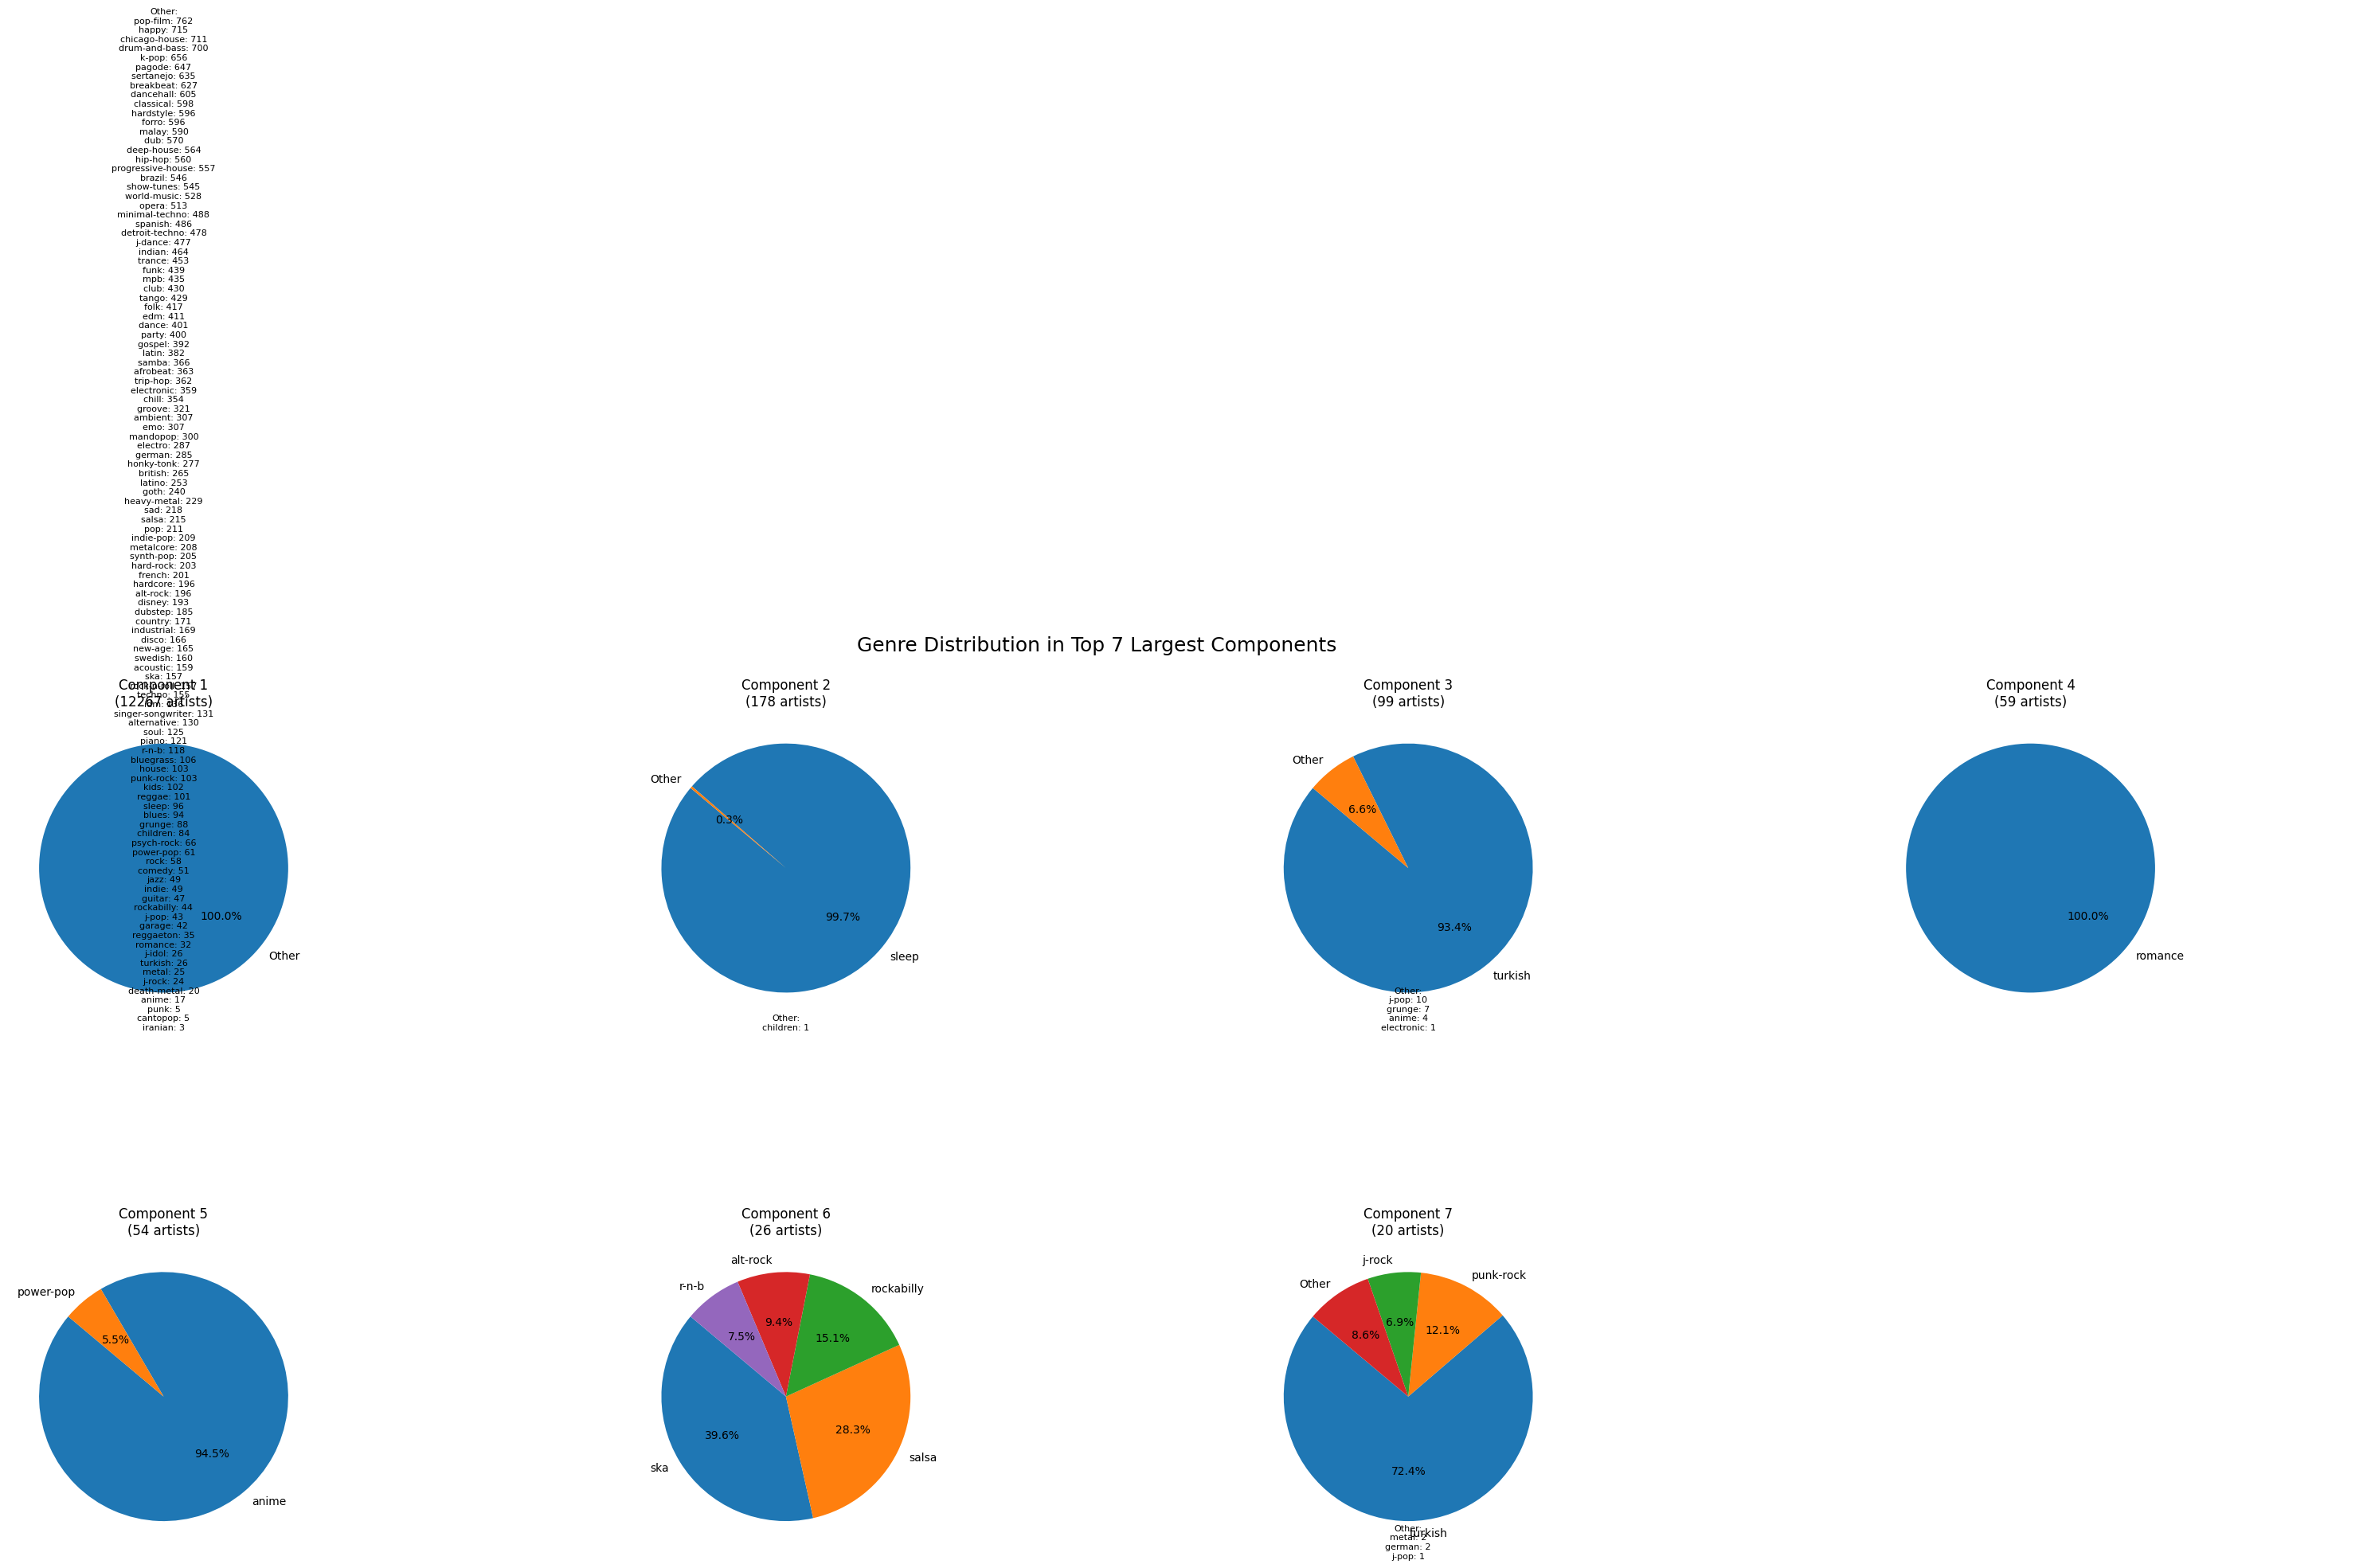

In [47]:
import matplotlib.pyplot as plt
from collections import Counter
import networkx as nx

# Get top 7 largest components
top_components = sorted(nx.connected_components(G), key=len, reverse=True)[:7]

# Set up subplots
fig, axs = plt.subplots(2, 4, figsize=(32, 12))
axs = axs.flatten()
fig.suptitle("Genre Distribution in Top 7 Largest Components", fontsize=18)

for idx, component_nodes in enumerate(top_components):
    subgraph = G.subgraph(component_nodes)
    
    # Track unique songs by name
    seen_songs = set()
    genre_counter = Counter()

    for _, _, data in subgraph.edges(data=True):
        song_id = data.get('track_name')  # Assuming 'track_name' uniquely identifies the song
        if song_id not in seen_songs:
            seen_songs.add(song_id)
            genre = data.get('genre', 'Unknown')
            genre_counter[genre] += 1

    # Prepare pie chart data
    labels, sizes = zip(*genre_counter.most_common()) if genre_counter else ([], [])
    total = sum(sizes)
    threshold = 0.05 * total
    new_labels, new_sizes, other_genres = [], [], {}

    for label, size in zip(labels, sizes):
        if size >= threshold:
            new_labels.append(label)
            new_sizes.append(size)
        else:
            other_genres[label] = size

    if other_genres:
        new_labels.append("Other")
        new_sizes.append(sum(other_genres.values()))

    # Draw chart
    axs[idx].pie(new_sizes, labels=new_labels, autopct='%1.1f%%', startangle=140)
    axs[idx].set_title(f"Component {idx + 1}\n({len(component_nodes)} artists)")

    if other_genres:
        other_text = "\n".join([f"{g}: {c}" for g, c in sorted(other_genres.items(), key=lambda x: -x[1])])
        axs[idx].text(0, -1.3, f"Other:\n{other_text}", ha='center', fontsize=8)

# Hide unused subplot if fewer than 8
for j in range(len(top_components), len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [48]:
# Get the biggest component
giant_component_nodes = top_components[0]
giant_subgraph = G.subgraph(giant_component_nodes)

# Collect genres from unique songs in the giant component
giant_seen_songs = set()
giant_genres = set()

for _, _, data in giant_subgraph.edges(data=True):
    song_id = data.get('track_name')
    if song_id not in giant_seen_songs:
        giant_seen_songs.add(song_id)
        giant_genres.add(data.get('genre', 'Unknown'))

# Check genres from components 2–7
print("Checking dominant genre from each smaller component against the giant component:\n")

for idx in range(1, 7):
    component_nodes = top_components[idx]
    subgraph = G.subgraph(component_nodes)

    seen_songs = set()
    genre_counter = Counter()

    for _, _, data in subgraph.edges(data=True):
        song_id = data.get('track_name')
        if song_id not in seen_songs:
            seen_songs.add(song_id)
            genre_counter[data.get('genre', 'Unknown')] += 1

    if genre_counter:
        top_genre, count = genre_counter.most_common(1)[0]
        present = top_genre in giant_genres
        print(f"Component {idx + 1} (size {len(component_nodes)}):")
        print(f"  - Top Genre: {top_genre} ({count} songs)")
        print(f"  - Present in Giant Component? {'✅ Yes' if present else '❌ No'}\n")
    else:
        print(f"Component {idx + 1}: No genre info found.\n")

Checking dominant genre from each smaller component against the giant component:

Component 2 (size 178):
  - Top Genre: sleep (352 songs)
  - Present in Giant Component? ✅ Yes

Component 3 (size 99):
  - Top Genre: turkish (312 songs)
  - Present in Giant Component? ✅ Yes

Component 4 (size 59):
  - Top Genre: romance (150 songs)
  - Present in Giant Component? ✅ Yes

Component 5 (size 54):
  - Top Genre: anime (69 songs)
  - Present in Giant Component? ✅ Yes

Component 6 (size 26):
  - Top Genre: ska (21 songs)
  - Present in Giant Component? ✅ Yes

Component 7 (size 20):
  - Top Genre: turkish (42 songs)
  - Present in Giant Component? ✅ Yes



/tmp/ipykernel_8374/332737983.py:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_nodes = cm.get_cmap('viridis')
/tmp/ipykernel_8374/332737983.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_edges = cm.get_cmap('plasma')


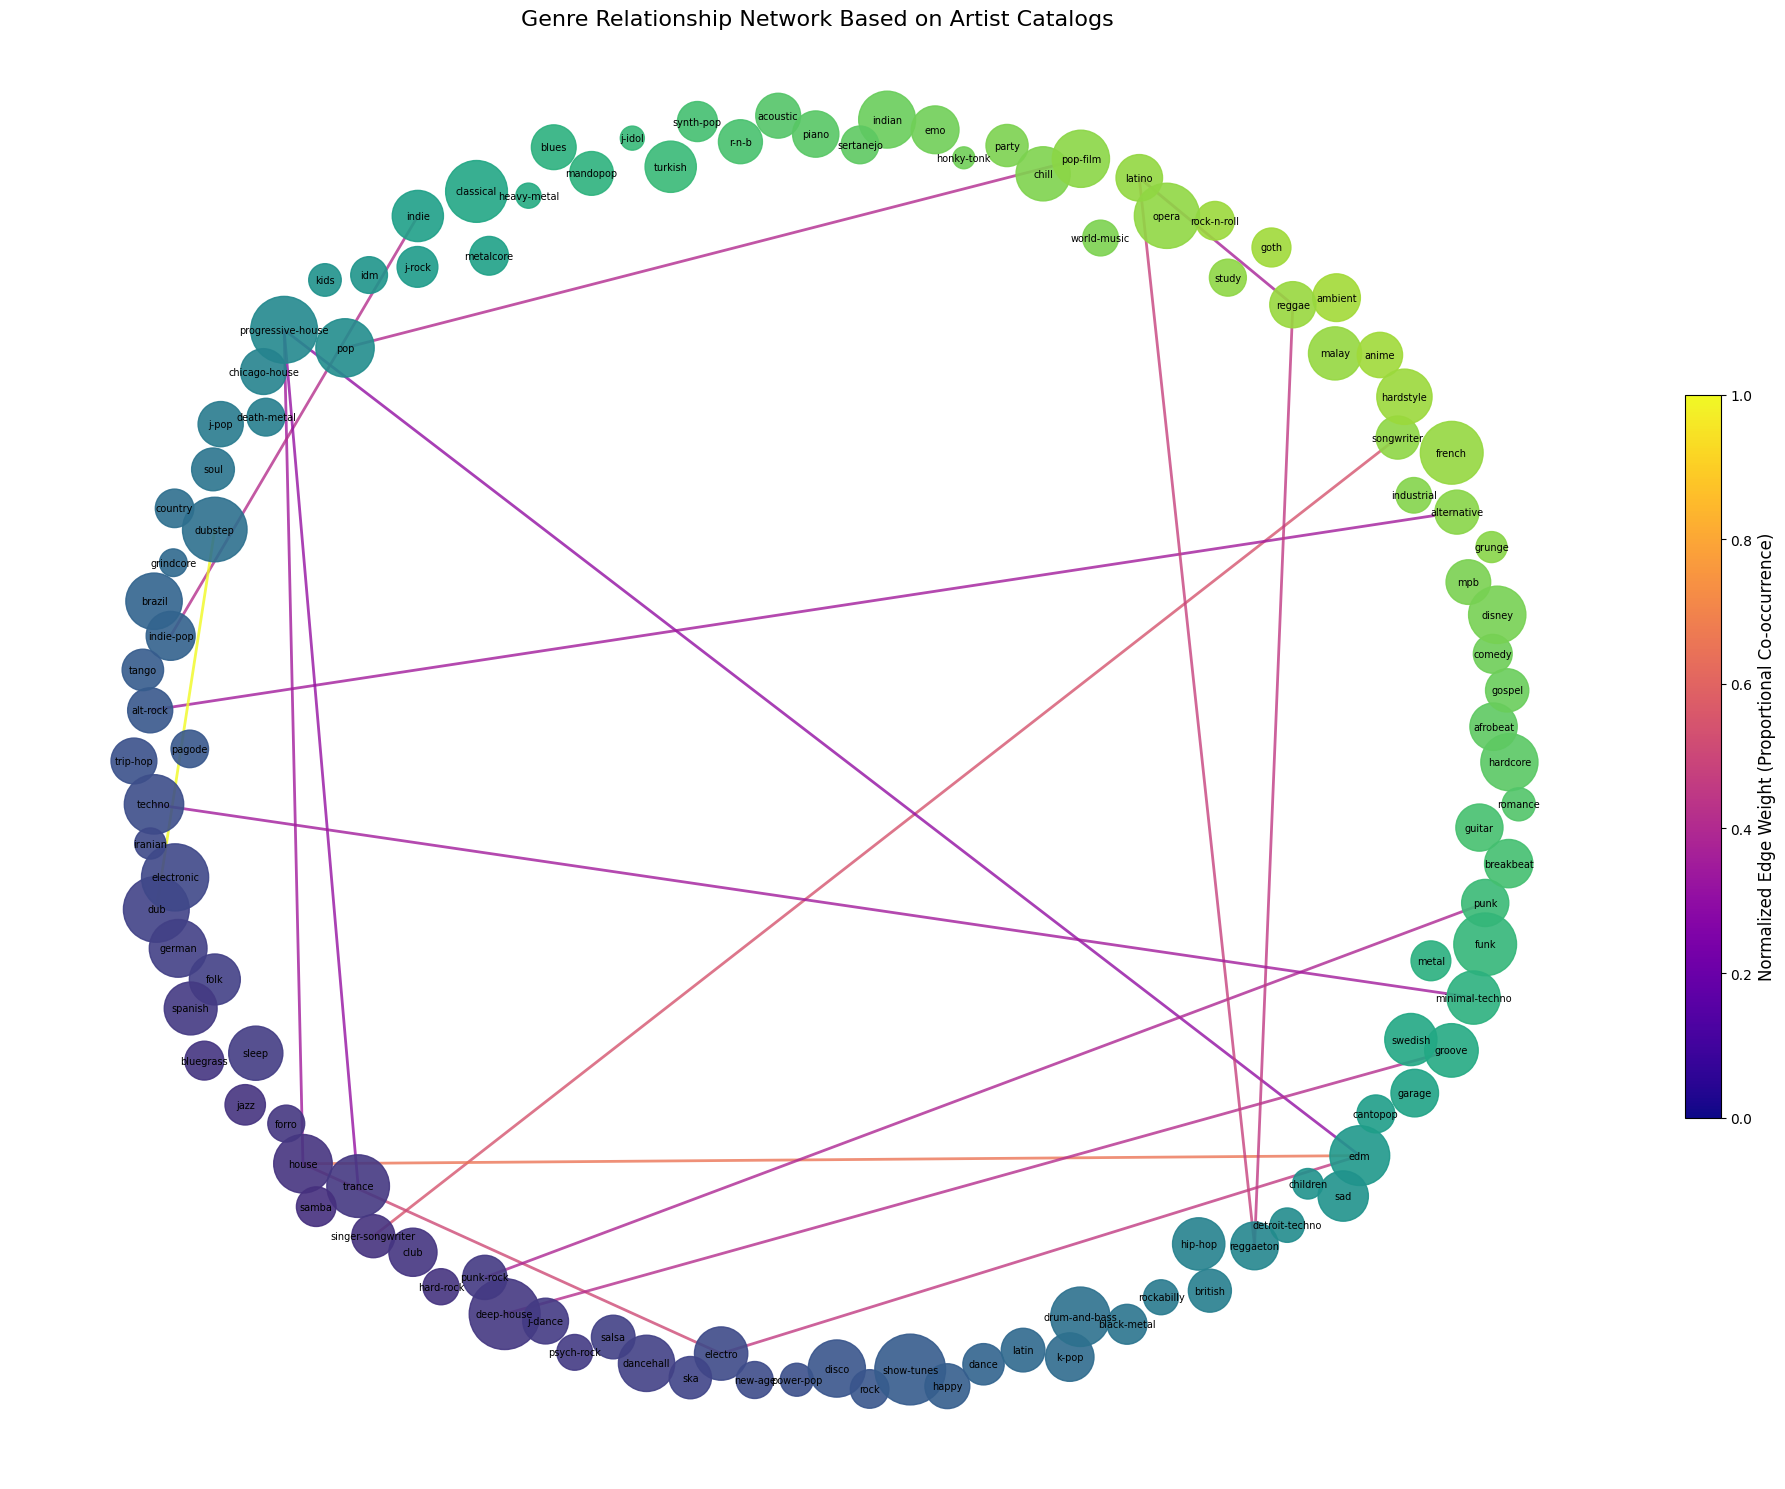

In [18]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict

# Step 1: Build artist_to_genres from your real dataframe
artist_to_genres = defaultdict(set)

for _, row in df.iterrows():
    artists = row['artists']          # List of artist IDs
    genre = row.get('track_genre', 'Unknown')
    
    for artist in artists:
        artist_to_genres[artist].add(genre)

# Step 2: Count genre occurrences and co-occurrences for each artist
genre_counts = defaultdict(int)
genre_pair_counts = defaultdict(int)

for genres in artist_to_genres.values():
    genres = list(genres)
    for i in range(len(genres)):
        genre_counts[genres[i]] += 1
        for j in range(i + 1, len(genres)):
            g1, g2 = sorted((genres[i], genres[j]))
            genre_pair_counts[(g1, g2)] += 1

# Step 3: Normalize edge weights (co-occurrences)
all_pairs = list(genre_pair_counts.items())
counts = np.array([count for _, count in all_pairs]).reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
normalized_weights = scaler.fit_transform(counts).flatten()

# Prune weak edges based on normalized weight
min_norm_weight = 0.3  # Adjust this threshold as needed
filtered_edges = [(g1, g2, norm_w) for ((g1, g2), norm_w) in zip([k for k, _ in all_pairs], normalized_weights) if norm_w >= min_norm_weight]

# Step 4: Build graph
G_genre = nx.Graph()

# Add genre nodes
for genre, count in genre_counts.items():
    G_genre.add_node(genre, size=count)

# Add filtered edges
for g1, g2, norm_w in filtered_edges:
    G_genre.add_edge(g1, g2, weight=norm_w)

# Step 5: Visualize the graph
fig, ax = plt.subplots(figsize=(20, 15))

# Layout
pos = nx.spring_layout(G_genre, seed=42, k=3.0, iterations=100)

# Node color encoding based on position
positions = np.array([pos[node] for node in G_genre.nodes()])
min_pos = positions.min(axis=0)
max_pos = positions.max(axis=0)
norm_positions = (positions - min_pos) / (max_pos - min_pos + 1e-9)
color_vals = norm_positions[:, 0] * 0.5 + norm_positions[:, 1] * 0.5
cmap_nodes = cm.get_cmap('viridis')
node_colors = cmap_nodes(color_vals)

# Node sizes
node_sizes = [G_genre.nodes[n]['size'] * 3 for n in G_genre.nodes()]

# Get normalized weights for coloring edges
norm_weights = np.array([G_genre[u][v]['weight'] for u, v in G_genre.edges()])
cmap_edges = cm.get_cmap('plasma')
edge_colors = [cmap_edges(w) for w in norm_weights]

# Draw
nx.draw_networkx_nodes(G_genre, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9, ax=ax)
nx.draw_networkx_edges(G_genre, pos, edge_color=edge_colors, width=2, alpha=0.8, ax=ax)
nx.draw_networkx_labels(G_genre, pos, font_size=7, ax=ax)

# Colorbar for edges (reflects normalized values)
sm = cm.ScalarMappable(cmap=cmap_edges, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, shrink=0.5, pad=0.03)
cbar.set_label('Normalized Edge Weight (Proportional Co-occurrence)', fontsize=12)

ax.set_title("Genre Relationship Network Based on Artist Catalogs", fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()

/tmp/ipykernel_8374/492434805.py:107: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_nodes = cm.get_cmap('viridis')
/tmp/ipykernel_8374/492434805.py:115: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_edges = cm.get_cmap('plasma')


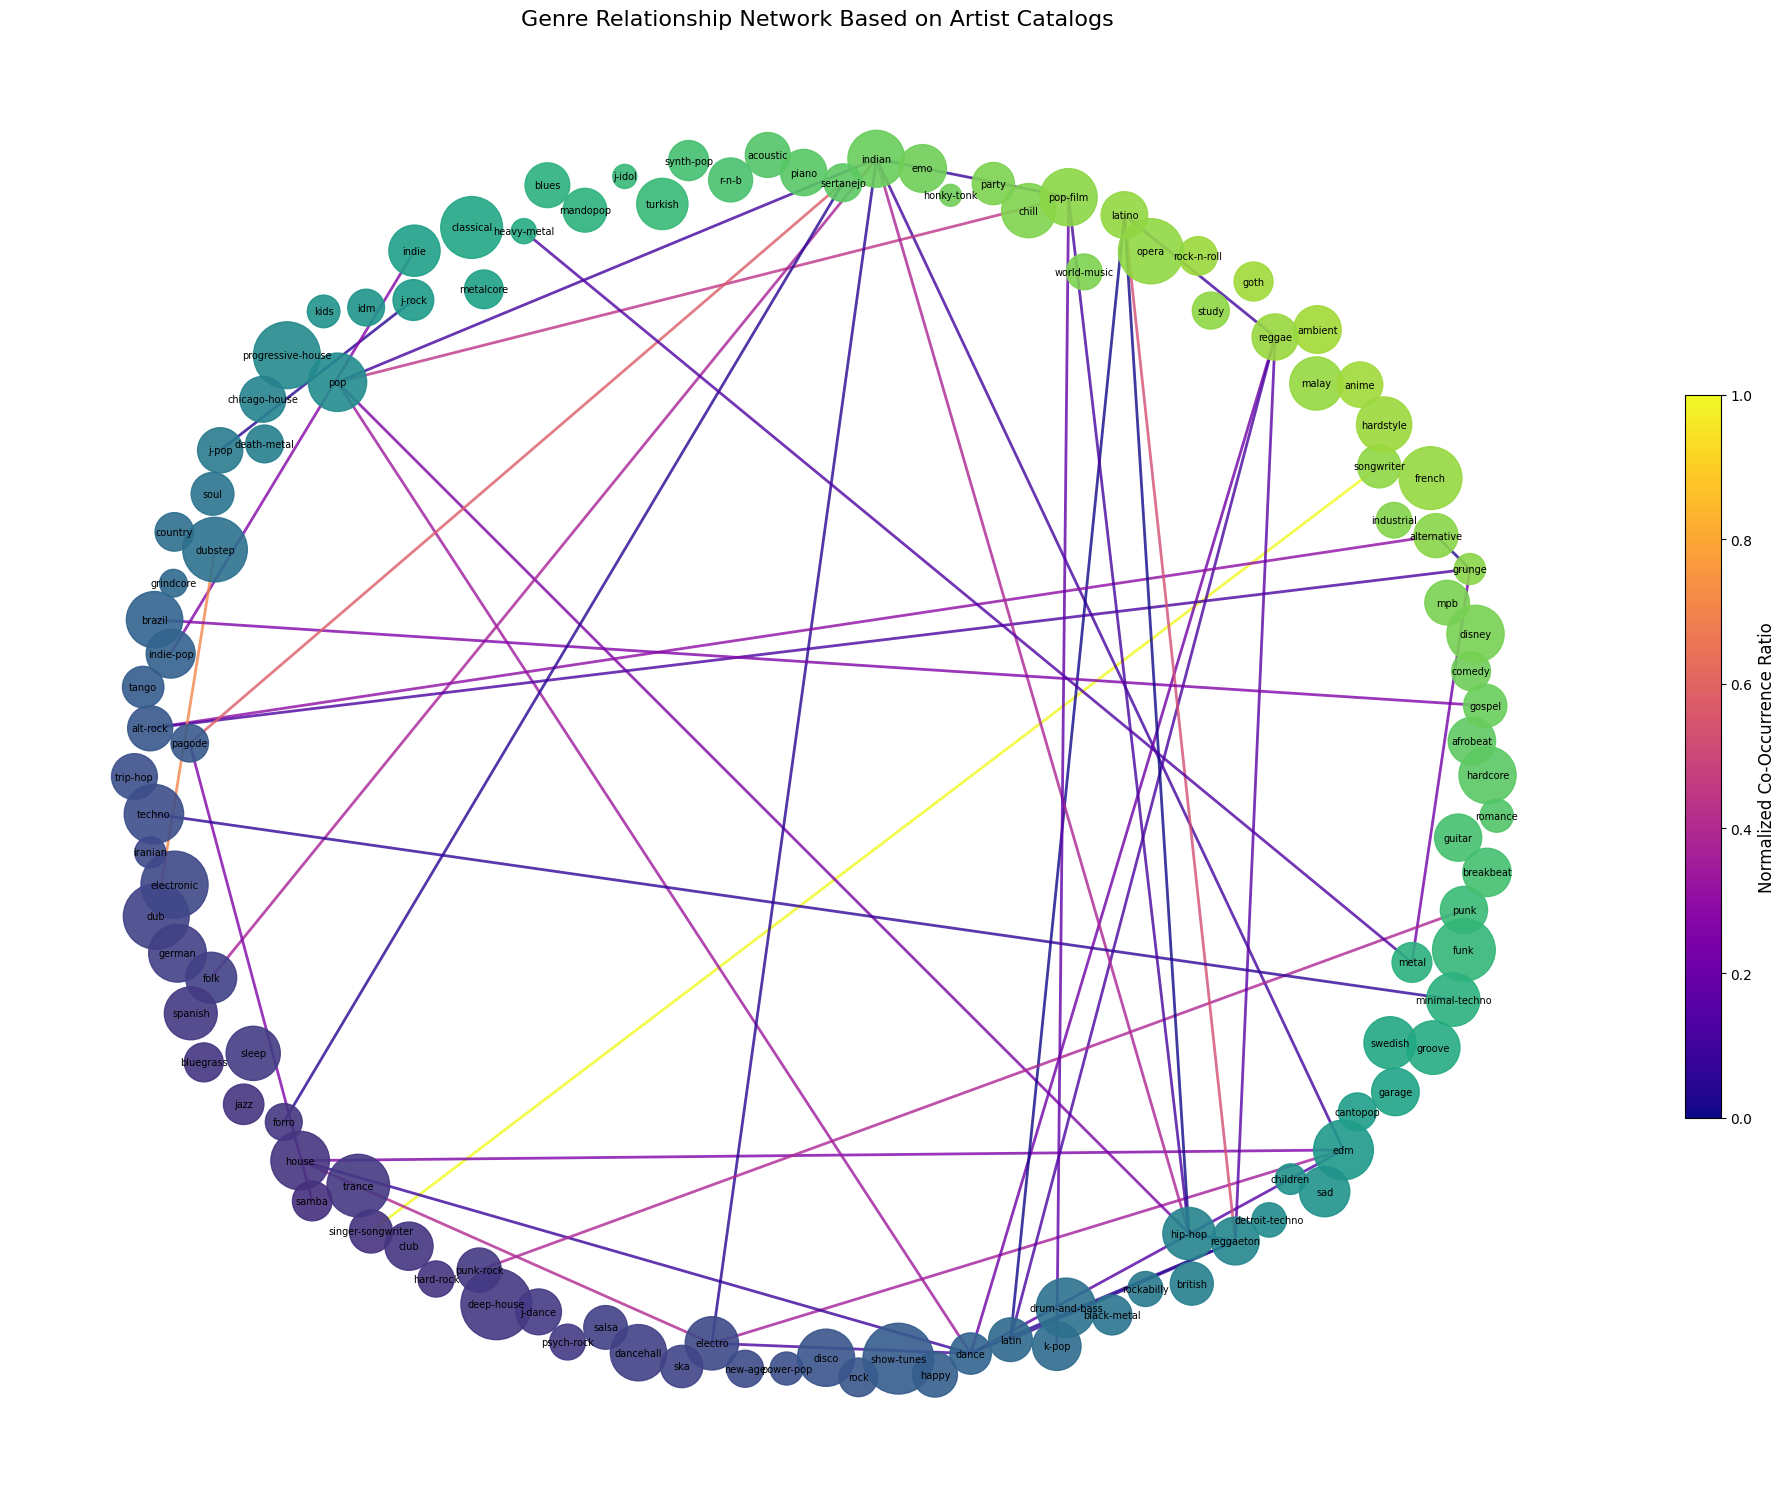

In [22]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
import matplotlib.colors as mcolors

# Get a set of unique genres from the DataFrame
unique_genres = set(df['track_genre'].dropna().unique())

# Step 1: Build artist_to_genres from your real dataframe
artist_to_genres = defaultdict(lambda: defaultdict(int))

for _, row in df.iterrows():
    artists = row['artists']          # List of artist IDs
    genre = row.get('track_genre', 'Unknown')
    
    for artist in artists:
        artist_to_genres[artist][genre] += 1

# Step 2: Count genre occurrences and co-occurrences for each artist
genre_pair_relation_aux = defaultdict(lambda: defaultdict(lambda: [0, 0]))

for genres in artist_to_genres.values():
    genres = list(genres.items())
    genres_set = set(g[0] for g in genres)

    for i in range(len(genres)):
        g1, count1 = genres[i]
        for j in range(i + 1, len(genres)):
            g2, count2 = genres[j]
            if count2 > 0:
                ratio = count1 / count2
                genre_pair_relation_aux[g1][g2][0] += ratio
                genre_pair_relation_aux[g1][g2][1] += 1
                genre_pair_relation_aux[g2][g1][0] += 1 / ratio
                genre_pair_relation_aux[g2][g1][1] += 1
            else:
                genre_pair_relation_aux[g1][g2][1] += 1
                genre_pair_relation_aux[g2][g1][1] += 1

    # Add penalty for missing genres
    for genre in unique_genres:
        if genre not in genres_set:
            for g in genres_set:
                genre_pair_relation_aux[genre][g][1] += 1
                genre_pair_relation_aux[g][genre][1] += 1

# Final genre pair similarity score (averaged ratios)
genre_pair_counts = {}
for g1, relations in genre_pair_relation_aux.items():
    for g2, (ratio_sum, count) in relations.items():
        if count > 0:
            genre_pair_counts[(g1, g2)] = ratio_sum / count

# Additional: genre frequency (for node sizes)
artist_to_genres_set = defaultdict(set)
for _, row in df.iterrows():
    artists = row['artists']
    genre = row.get('track_genre', 'Unknown')
    for artist in artists:
        artist_to_genres_set[artist].add(genre)

genre_counts = defaultdict(int)
for genres in artist_to_genres_set.values():
    for genre in genres:
        genre_counts[genre] += 1

# Step 3: Build genre co-occurrence graph with edge weight threshold
min_weight = 0.4  # Ratio threshold instead of absolute count now (adjust as needed)

# Filter and collect only valid edges
filtered_edges = [(g1, g2, weight) for (g1, g2), weight in genre_pair_counts.items() if weight >= min_weight]

if not filtered_edges:
    raise ValueError("No edges meet the threshold. Consider lowering min_weight.")

# Normalize the edge weights (ratios) between 0 and 1
original_weights = np.array([weight for (_, _, weight) in filtered_edges]).reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_weights = scaler.fit_transform(original_weights).flatten()

# Build graph
G_genre = nx.Graph()

# Add genre nodes (node size = number of artists associated with the genre)
for genre, count in genre_counts.items():
    G_genre.add_node(genre, size=count)

# Add normalized weighted edges
for (g1, g2, _), norm_w in zip(filtered_edges, normalized_weights):
    G_genre.add_edge(g1, g2, weight=norm_w)

# Step 4: Visualize the graph
fig, ax = plt.subplots(figsize=(20, 15))

# Layout
pos = nx.spring_layout(G_genre, seed=42, k=3.0, iterations=100)

# Node color encoding based on position
positions = np.array([pos[node] for node in G_genre.nodes()])
min_pos = positions.min(axis=0)
max_pos = positions.max(axis=0)
norm_positions = (positions - min_pos) / (max_pos - min_pos + 1e-9)
color_vals = norm_positions[:, 0] * 0.5 + norm_positions[:, 1] * 0.5
cmap_nodes = cm.get_cmap('viridis')
node_colors = cmap_nodes(color_vals)

# Node sizes (scale if needed)
node_sizes = [G_genre.nodes[n]['size'] * 3 for n in G_genre.nodes()]

# Edge coloring
norm_weights = np.array([G_genre[u][v]['weight'] for u, v in G_genre.edges()])
cmap_edges = cm.get_cmap('plasma')
edge_colors = [cmap_edges(w) for w in norm_weights]

# Draw nodes, edges, and labels
nx.draw_networkx_nodes(G_genre, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9, ax=ax)
nx.draw_networkx_edges(G_genre, pos, edge_color=edge_colors, width=2, alpha=0.8, ax=ax)
nx.draw_networkx_labels(G_genre, pos, font_size=7, ax=ax)

# Colorbar for edges (reflects normalized co-occurrence ratios)
sm = cm.ScalarMappable(cmap=cmap_edges, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, shrink=0.5, pad=0.03)
cbar.set_label('Normalized Co-Occurrence Ratio', fontsize=12)

ax.set_title("Genre Relationship Network Based on Artist Catalogs", fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()

In [51]:
!pip install circlify

Defaulting to user installation because normal site-packages is not writeable


In [32]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle
import matplotlib.colors as mcolors

def plot_genre_bubble_hierarchy(target_genre, genre_pair_counts, genre_counts, step=0.1):
    thresholds = np.arange(0.9, -0.01, -step)
    seen = set()
    hierarchy_data = []
    
    # Build hierarchy data
    for level, threshold in enumerate(thresholds):
        layer_genres = []
        
        # Always include target genre at level 0
        if level == 0:
            target_datum = genre_counts.get(target_genre, 1)
            layer_genres.append({
                'id': target_genre,
                'datum': target_datum,
                'is_target': True
            })
            seen.add(target_genre)
        else:
            # Find connected genres for this threshold
            for (g1, g2), w in genre_pair_counts.items():
                if w >= threshold:
                    if g1 == target_genre and g2 not in seen:
                        seen.add(g2)
                        layer_genres.append({
                            'id': g2, 
                            'datum': genre_counts.get(g2, 1),
                            'is_target': False
                        })
                    elif g2 == target_genre and g1 not in seen:
                        seen.add(g1)
                        layer_genres.append({
                            'id': g1, 
                            'datum': genre_counts.get(g1, 1),
                            'is_target': False
                        })
        
        if layer_genres:
            hierarchy_data.append({
                'threshold': threshold,
                'level': level,
                'genres': layer_genres,
                'total_datum': sum(item['datum'] for item in layer_genres)
            })
    
    if not hierarchy_data:
        print(f"No data found for genre: {target_genre}")
        return
    
    # Create the hierarchical layout with proper spacing
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.set_title(f"Bubble Hierarchy for Genre: '{target_genre}'", fontsize=16, pad=20)
    
    # Color schemes
    colors = plt.cm.Set3(np.linspace(0, 1, len(hierarchy_data)))
    
    # Calculate proper radii for each level to prevent overlap
    base_radius = 0.1
    level_radii = []
    
    for i, layer in enumerate(hierarchy_data):
        if i == 0:
            level_radii.append(0)  # Target at center
        else:
            # Calculate minimum radius needed for this level
            num_genres = len(layer['genres'])
            if num_genres > 0:
                # Calculate circumference needed for all bubbles with padding
                bubble_radius = 0.03  # Base bubble size
                min_spacing = bubble_radius * 2.5  # Minimum spacing between bubbles
                required_circumference = num_genres * min_spacing
                required_radius = required_circumference / (2 * np.pi)
                
                # Ensure each level is sufficiently separated
                min_level_radius = base_radius + (i - 1) * 0.15
                actual_radius = max(required_radius, min_level_radius)
                level_radii.append(actual_radius)
    
    center_x, center_y = 0, 0
    
    # Draw each level
    for layer_idx, layer in enumerate(hierarchy_data):
        layer_radius = level_radii[layer_idx]
        
        # Draw container circle for this threshold level (except for target)
        if layer_idx > 0:
            container_circle = Circle(
                (center_x, center_y), 
                layer_radius + 0.05,  # Slightly larger than the content
                fill=False, 
                linewidth=2, 
                edgecolor=colors[layer_idx],
                alpha=0.7
            )
            ax.add_patch(container_circle)
            
            # Add threshold label positioned to avoid overlap
            label_angle = np.pi / 4  # 45 degrees
            label_x = center_x + (layer_radius + 0.1) * np.cos(label_angle)
            label_y = center_y + (layer_radius + 0.1) * np.sin(label_angle)
            
            ax.text(
                label_x, label_y,
                f'≥ {layer["threshold"]:.1f}',
                ha='center', 
                va='center', 
                fontsize=10,
                color=colors[layer_idx],
                weight='bold',
                bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8)
            )
        
        # Position genres within this layer
        genres = layer['genres']
        
        if len(genres) == 1:
            # Single genre (target) - place at center
            genre = genres[0]
            genre_radius = 0.08
            genre_x, genre_y = center_x, center_y
            
            # Draw genre bubble
            color = 'red' if genre['is_target'] else colors[layer_idx]
            circle = Circle(
                (genre_x, genre_y), 
                genre_radius, 
                alpha=0.8, 
                facecolor=color,
                edgecolor='black',
                linewidth=2
            )
            ax.add_patch(circle)
            
            # Add genre label
            ax.text(
                genre_x, genre_y, 
                genre['id'], 
                ha='center', va='center', 
                fontsize=12,
                weight='bold',
                color='black'
            )
        else:
            # Multiple genres - arrange in circle with proper spacing
            for i, genre in enumerate(genres):
                angle = 2 * np.pi * i / len(genres)
                
                # Position at the calculated radius for this level
                genre_x = center_x + layer_radius * np.cos(angle)
                genre_y = center_y + layer_radius * np.sin(angle)
                
                # Genre bubble size based on its datum
                max_genre_datum = max(g['datum'] for g in genres)
                min_genre_datum = min(g['datum'] for g in genres)
                if max_genre_datum == min_genre_datum:
                    genre_radius = 0.025
                else:
                    genre_radius = 0.015 + 0.02 * (genre['datum'] - min_genre_datum) / (max_genre_datum - min_genre_datum)
                
                # Draw genre bubble
                color = 'red' if genre['is_target'] else colors[layer_idx]
                circle = Circle(
                    (genre_x, genre_y), 
                    genre_radius, 
                    alpha=0.7, 
                    facecolor=color,
                    edgecolor='black',
                    linewidth=1
                )
                ax.add_patch(circle)
                
                # Add genre label
                ax.text(
                    genre_x, genre_y, 
                    genre['id'], 
                    ha='center', va='center', 
                    fontsize=8,
                    weight='bold' if genre['is_target'] else 'normal',
                    color='black'
                )
    
    # Calculate axis limits based on the outermost level
    max_radius = max(level_radii) + 0.2 if level_radii else 1
    ax.set_xlim(-max_radius, max_radius)
    ax.set_ylim(-max_radius, max_radius)
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
                   markersize=10, label=f'Target: {target_genre}'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', 
                   markersize=8, label='Related Genres'),
        plt.Line2D([0], [0], color='gray', linewidth=2, label='Threshold Boundaries')
    ]
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0, 1))
    
    plt.tight_layout()
    plt.show()

# Alternative advanced version with better hierarchical layout
def plot_genre_bubble_hierarchy_advanced(target_genre, genre_pair_counts, genre_counts, step=0.1):
    """
    Advanced version with improved non-overlapping layout
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle
    import numpy as np
    
    # Build hierarchy data (same as before)
    thresholds = np.arange(0.9, -0.01, -step)
    seen = set()
    hierarchy_data = []
    
    for level, threshold in enumerate(thresholds):
        layer_genres = []
        
        if level == 0:
            target_datum = genre_counts.get(target_genre, 1)
            layer_genres.append({
                'id': target_genre,
                'datum': target_datum,
                'is_target': True
            })
            seen.add(target_genre)
        else:
            for (g1, g2), w in genre_pair_counts.items():
                if w >= threshold:
                    if g1 == target_genre and g2 not in seen:
                        seen.add(g2)
                        layer_genres.append({
                            'id': g2, 
                            'datum': genre_counts.get(g2, 1),
                            'is_target': False
                        })
                    elif g2 == target_genre and g1 not in seen:
                        seen.add(g1)
                        layer_genres.append({
                            'id': g1, 
                            'datum': genre_counts.get(g1, 1),
                            'is_target': False
                        })
        
        if layer_genres:
            hierarchy_data.append({
                'threshold': threshold,
                'level': level,
                'genres': layer_genres,
                'total_datum': sum(item['datum'] for item in layer_genres)
            })
    
    if not hierarchy_data:
        print(f"No data found for genre: {target_genre}")
        return
    
    # Create improved nested layout
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.set_title(f"Hierarchical Bubble Chart for Genre: '{target_genre}'", fontsize=18, pad=20)
    
    # Colors for different threshold levels
    colors = plt.cm.tab10(np.linspace(0, 1, len(hierarchy_data)))
    
    # Calculate proper nested radii with sufficient spacing
    center_x, center_y = 0, 0
    level_radii = []
    
    for i, layer in enumerate(hierarchy_data):
        if i == 0:
            level_radii.append(0)  # Target at center
        else:
            # Calculate minimum radius needed based on number of genres
            num_genres = len(layer['genres'])
            if num_genres > 0:
                # Calculate space needed for bubbles
                bubble_radius = 0.04  # Maximum bubble size
                min_spacing = bubble_radius * 3  # Generous spacing
                required_circumference = num_genres * min_spacing
                required_radius = required_circumference / (2 * np.pi)
                
                # Ensure progressive spacing between levels
                min_level_separation = 0.2  # Minimum separation between levels
                previous_radius = level_radii[i-1] if i > 0 else 0
                min_radius = previous_radius + min_level_separation
                
                actual_radius = max(required_radius, min_radius)
                level_radii.append(actual_radius)
    
    # Draw from outside to inside for proper layering
    for layer_idx in reversed(range(len(hierarchy_data))):
        layer = hierarchy_data[layer_idx]
        layer_radius = level_radii[layer_idx]
        
        if layer_idx == 0:
            # Draw target genre at center
            genre = layer['genres'][0]
            circle = Circle(
                (center_x, center_y), 
                0.08, 
                alpha=0.9, 
                facecolor='red',
                edgecolor='darkred',
                linewidth=3
            )
            ax.add_patch(circle)
            
            ax.text(
                center_x, center_y, 
                genre['id'], 
                ha='center', va='center', 
                fontsize=14,
                weight='bold',
                color='black'
            )
        else:
            # Draw container circle
            container_circle = Circle(
                (center_x, center_y), 
                layer_radius + 0.08,  # Buffer around the content
                fill=False, 
                linewidth=3, 
                edgecolor=colors[layer_idx],
                alpha=0.8
            )
            ax.add_patch(container_circle)
            
            # Add threshold label positioned to avoid overlap
            label_angle = np.pi / 6 + (layer_idx * np.pi / 12)  # Staggered angles
            label_radius = layer_radius + 0.12
            label_x = center_x + label_radius * np.cos(label_angle)
            label_y = center_y + label_radius * np.sin(label_angle)
            
            ax.text(
                label_x, label_y,
                f'Similarity ≥ {layer["threshold"]:.1f}',
                ha='center', 
                va='center', 
                fontsize=11,
                color=colors[layer_idx],
                weight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.9)
            )
            
            # Position genres in this layer
            genres = layer['genres']
            
            for i, genre in enumerate(genres):
                angle = 2 * np.pi * i / len(genres)
                # Add slight angular offset to avoid alignment issues
                if len(genres) > 1:
                    angle += np.pi / len(genres) * 0.1
                
                genre_x = center_x + layer_radius * np.cos(angle)
                genre_y = center_y + layer_radius * np.sin(angle)
                
                # Genre bubble size with better scaling
                max_datum = max(g['datum'] for g in genres)
                min_datum = min(g['datum'] for g in genres)
                if max_datum == min_datum:
                    genre_radius = 0.025
                else:
                    genre_radius = 0.015 + 0.025 * (genre['datum'] - min_datum) / (max_datum - min_datum)
                
                # Draw genre bubble
                circle = Circle(
                    (genre_x, genre_y), 
                    genre_radius, 
                    alpha=0.8, 
                    facecolor=colors[layer_idx],
                    edgecolor='black',
                    linewidth=1
                )
                ax.add_patch(circle)
                
                # Add genre label
                ax.text(
                    genre_x, genre_y, 
                    genre['id'], 
                    ha='center', va='center', 
                    fontsize=9,
                    weight='normal',
                    color='black'
                )
    
    # Set axis properties with proper margins
    max_radius = max(level_radii) + 0.3 if level_radii else 1
    ax.set_xlim(-max_radius, max_radius)
    ax.set_ylim(-max_radius, max_radius)
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Add comprehensive legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
                   markersize=15, label=f'Target Genre: {target_genre}'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', 
                   markersize=10, label='Related Genres'),
        plt.Line2D([0], [0], color='gray', linewidth=3, label='Similarity Thresholds')
    ]
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0, 1), fontsize=12)
    
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_genre_bubble_hierarchy('reggaeton', genre_pair_counts, genre_counts)
# plot_genre_bubble_hierarchy_advanced('reggaeton', genre_pair_counts, genre_counts)

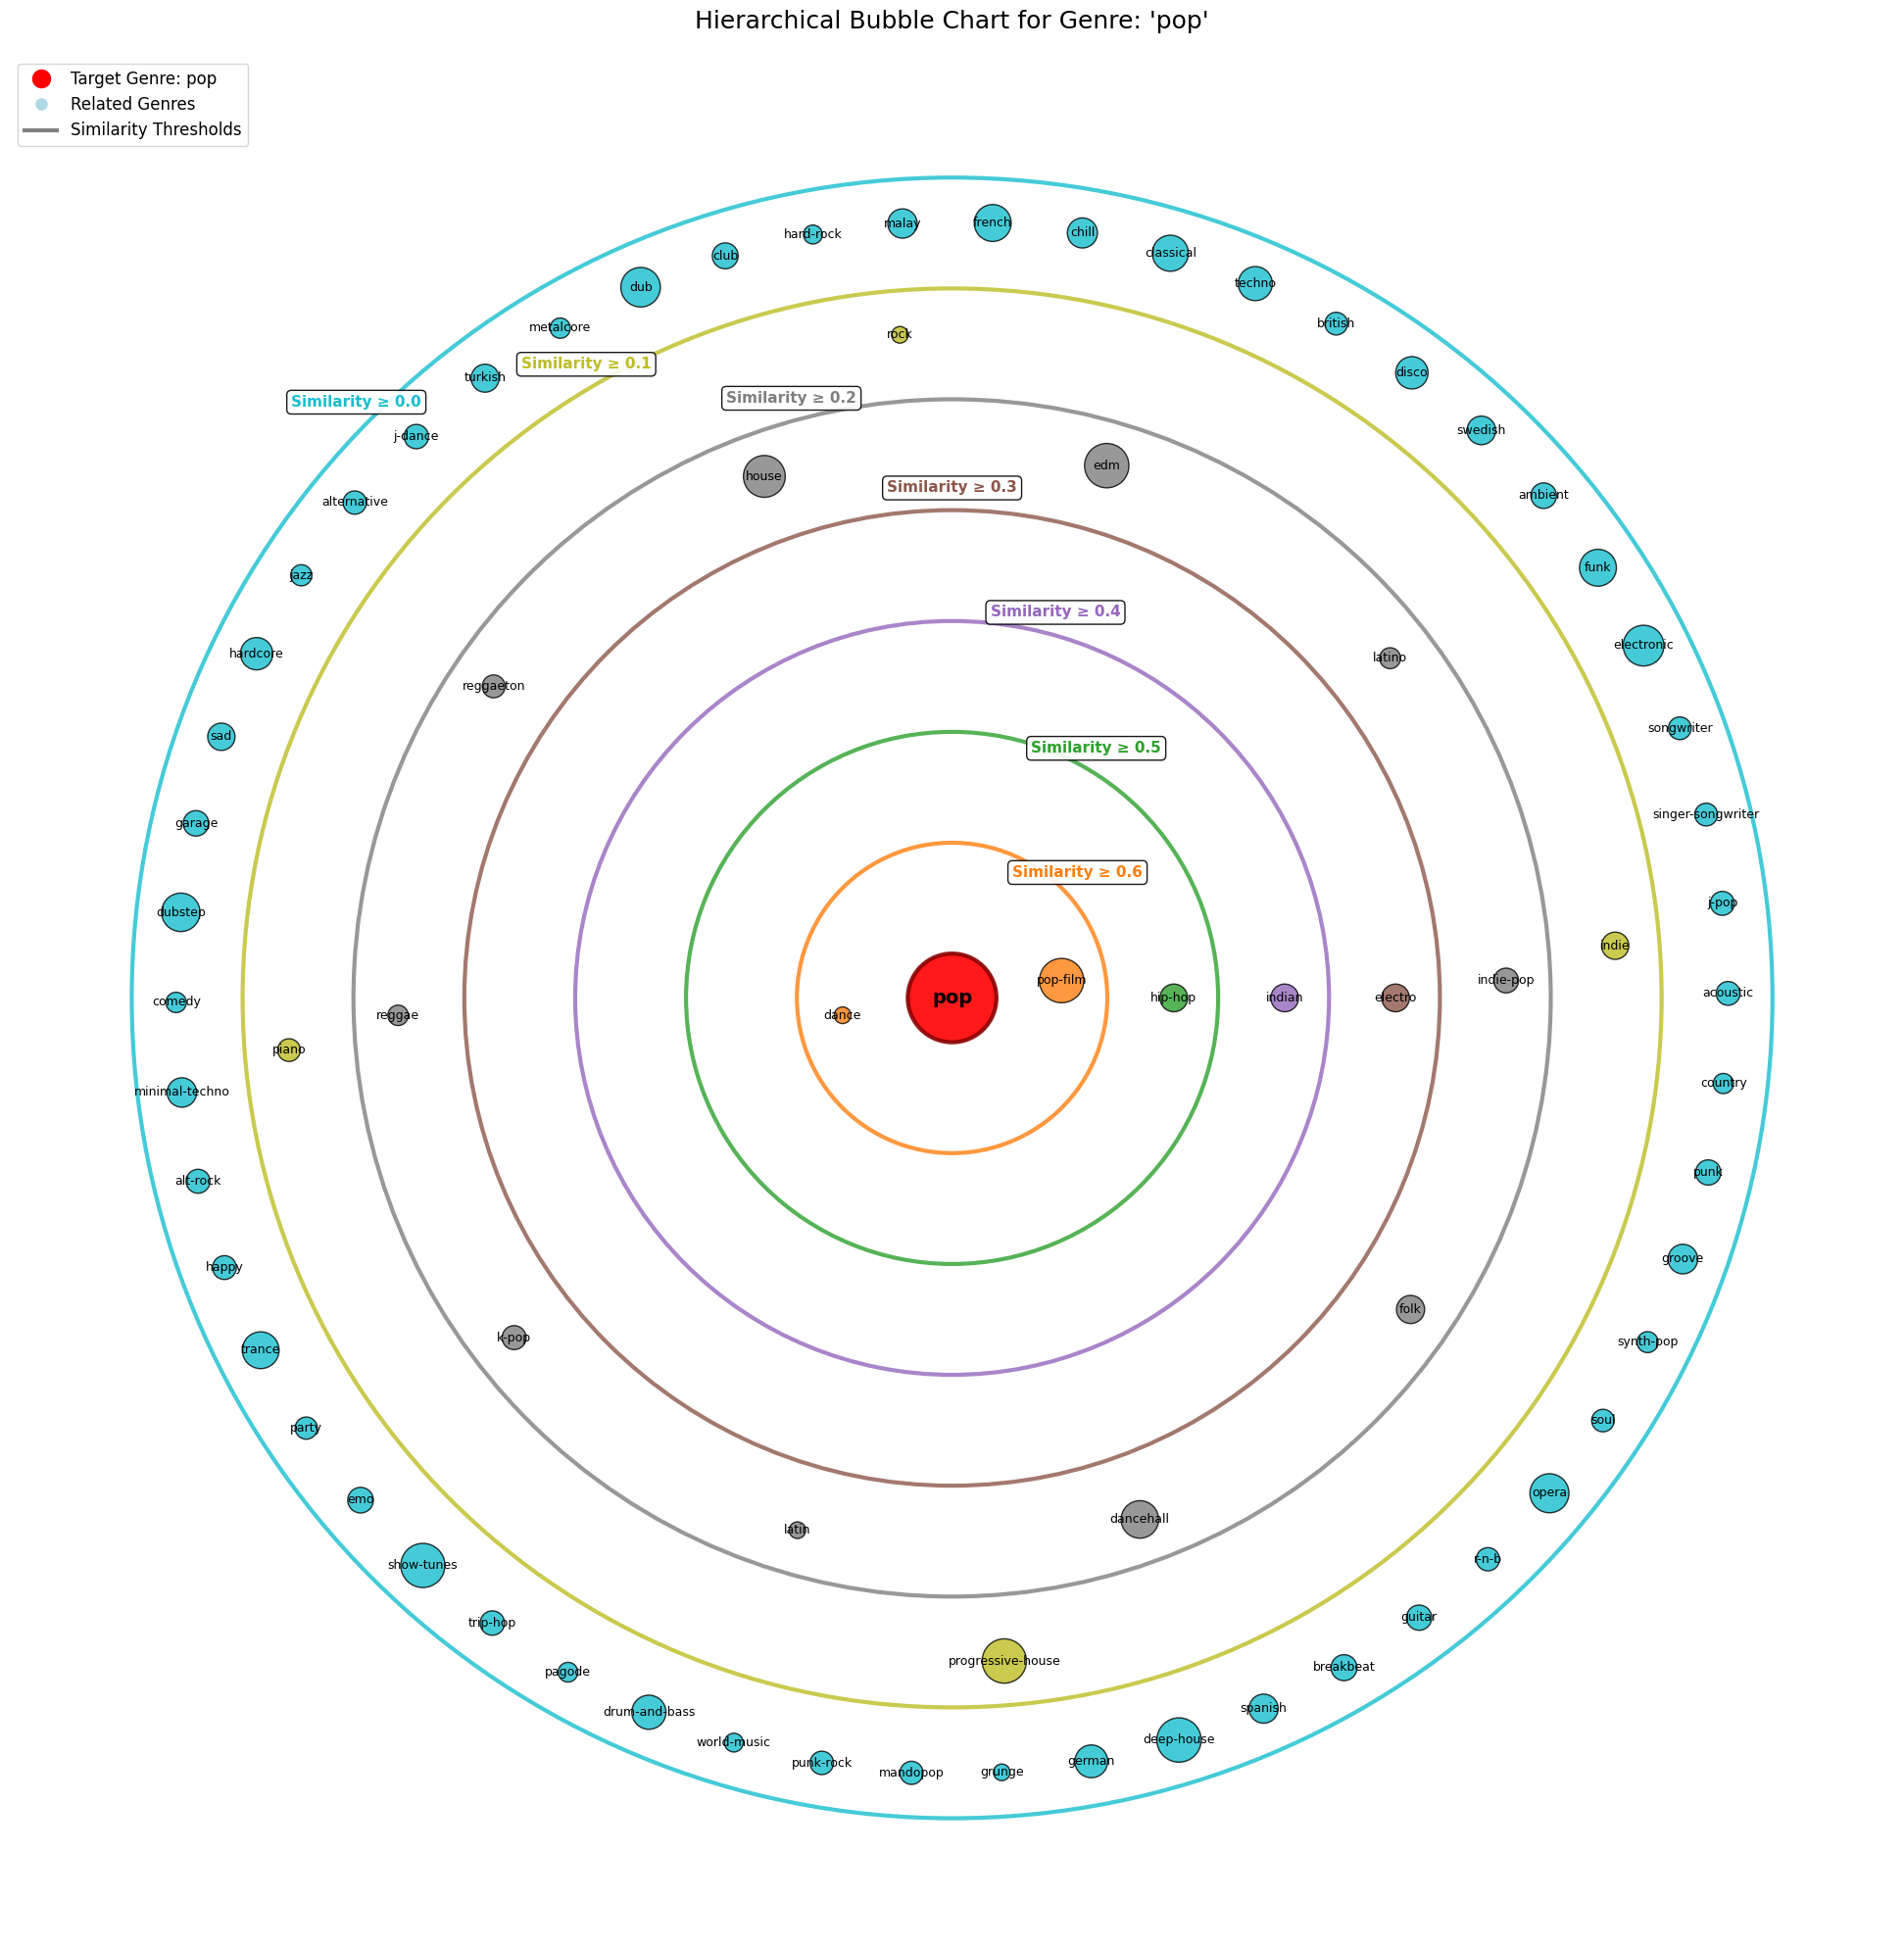

In [48]:
plot_genre_bubble_hierarchy_advanced('pop', genre_pair_counts, genre_counts)

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle
import matplotlib.colors as mcolors
import networkx as nx
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict

def create_genre_network_data(df):
    """
    Create genre network data from DataFrame (same as your NetworkX code)
    """
    # Step 1: Build artist_to_genres from your real dataframe
    artist_to_genres = defaultdict(set)
    for _, row in df.iterrows():
        artists = row['artists']  # List of artist IDs
        genre = row.get('track_genre', 'Unknown')
        for artist in artists:
            artist_to_genres[artist].add(genre)
    
    # Step 2: Count genre occurrences and co-occurrences for each artist
    genre_counts = defaultdict(int)
    genre_pair_counts = defaultdict(int)
    
    for genres in artist_to_genres.values():
        genres = list(genres)
        for i in range(len(genres)):
            genre_counts[genres[i]] += 1
            for j in range(i + 1, len(genres)):
                g1, g2 = sorted((genres[i], genres[j]))
                genre_pair_counts[(g1, g2)] += 1
    
    # Step 3: Normalize edge weights (co-occurrences)
    all_pairs = list(genre_pair_counts.items())
    counts = np.array([count for _, count in all_pairs]).reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    normalized_weights = scaler.fit_transform(counts).flatten()
    
    # Create normalized genre_pair_counts dictionary
    normalized_genre_pairs = {}
    for ((g1, g2), norm_w) in zip([k for k, _ in all_pairs], normalized_weights):
        normalized_genre_pairs[(g1, g2)] = norm_w
    
    return dict(genre_counts), normalized_genre_pairs

def plot_genre_bubble_hierarchy_networkx(target_genre, normalized_genre_pairs, genre_counts, step=0.1):
    """
    Plot bubble hierarchy using normalized weights from NetworkX analysis
    """
    thresholds = np.arange(0.9, -0.01, -step)
    seen = set()
    hierarchy_data = []
    
    # Build hierarchy data using normalized weights
    for level, threshold in enumerate(thresholds):
        layer_genres = []
        
        # Always include target genre at level 0
        if level == 0:
            target_datum = genre_counts.get(target_genre, 1)
            layer_genres.append({
                'id': target_genre,
                'datum': target_datum,
                'is_target': True
            })
            seen.add(target_genre)
        else:
            # Find connected genres for this threshold using normalized weights
            for (g1, g2), norm_weight in normalized_genre_pairs.items():
                if norm_weight >= threshold:
                    if g1 == target_genre and g2 not in seen:
                        seen.add(g2)
                        layer_genres.append({
                            'id': g2, 
                            'datum': genre_counts.get(g2, 1),
                            'is_target': False
                        })
                    elif g2 == target_genre and g1 not in seen:
                        seen.add(g1)
                        layer_genres.append({
                            'id': g1, 
                            'datum': genre_counts.get(g1, 1),
                            'is_target': False
                        })
        
        if layer_genres:
            hierarchy_data.append({
                'threshold': threshold,
                'level': level,
                'genres': layer_genres,
                'total_datum': sum(item['datum'] for item in layer_genres)
            })
    
    if not hierarchy_data:
        print(f"No data found for genre: {target_genre}")
        return
    
    # Create the hierarchical layout with proper spacing
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.set_title(f"Genre Relationship Hierarchy for: '{target_genre}'\n(Based on Artist Catalog Co-occurrence)", fontsize=16, pad=20)
    
    # Color schemes
    colors = plt.cm.Set3(np.linspace(0, 1, len(hierarchy_data)))
    
    # Calculate proper radii for each level to prevent overlap
    base_radius = 0.1
    level_radii = []
    
    for i, layer in enumerate(hierarchy_data):
        if i == 0:
            level_radii.append(0)  # Target at center
        else:
            # Calculate minimum radius needed for this level
            num_genres = len(layer['genres'])
            if num_genres > 0:
                # Calculate circumference needed for all bubbles with padding
                bubble_radius = 0.03  # Base bubble size
                min_spacing = bubble_radius * 2.5  # Minimum spacing between bubbles
                required_circumference = num_genres * min_spacing
                required_radius = required_circumference / (2 * np.pi)
                
                # Ensure each level is sufficiently separated
                min_level_radius = base_radius + (i - 1) * 0.15
                actual_radius = max(required_radius, min_level_radius)
                level_radii.append(actual_radius)
    
    center_x, center_y = 0, 0
    
    # Draw each level
    for layer_idx, layer in enumerate(hierarchy_data):
        layer_radius = level_radii[layer_idx]
        
        # Draw container circle for this threshold level (except for target)
        if layer_idx > 0:
            container_circle = Circle(
                (center_x, center_y), 
                layer_radius + 0.05,  # Slightly larger than the content
                fill=False, 
                linewidth=2, 
                edgecolor=colors[layer_idx],
                alpha=0.7
            )
            ax.add_patch(container_circle)
            
            # Add threshold label positioned to avoid overlap
            label_angle = np.pi / 4  # 45 degrees
            label_x = center_x + (layer_radius + 0.1) * np.cos(label_angle)
            label_y = center_y + (layer_radius + 0.1) * np.sin(label_angle)
            
            ax.text(
                label_x, label_y,
                f'Similarity ≥ {layer["threshold"]:.1f}',
                ha='center', 
                va='center', 
                fontsize=10,
                color=colors[layer_idx],
                weight='bold',
                bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8)
            )
        
        # Position genres within this layer
        genres = layer['genres']
        
        if len(genres) == 1:
            # Single genre (target) - place at center
            genre = genres[0]
            genre_radius = 0.08
            genre_x, genre_y = center_x, center_y
            
            # Draw genre bubble
            color = 'red' if genre['is_target'] else colors[layer_idx]
            circle = Circle(
                (genre_x, genre_y), 
                genre_radius, 
                alpha=0.8, 
                facecolor=color,
                edgecolor='black',
                linewidth=2
            )
            ax.add_patch(circle)
            
            # Add genre label
            ax.text(
                genre_x, genre_y, 
                genre['id'], 
                ha='center', va='center', 
                fontsize=12,
                weight='bold',
                color='black'
            )
        else:
            # Multiple genres - arrange in circle with proper spacing
            for i, genre in enumerate(genres):
                angle = 2 * np.pi * i / len(genres)
                
                # Position at the calculated radius for this level
                genre_x = center_x + layer_radius * np.cos(angle)
                genre_y = center_y + layer_radius * np.sin(angle)
                
                # Genre bubble size based on its datum
                max_genre_datum = max(g['datum'] for g in genres)
                min_genre_datum = min(g['datum'] for g in genres)
                if max_genre_datum == min_genre_datum:
                    genre_radius = 0.025
                else:
                    genre_radius = 0.015 + 0.02 * (genre['datum'] - min_genre_datum) / (max_genre_datum - min_genre_datum)
                
                # Draw genre bubble
                color = 'red' if genre['is_target'] else colors[layer_idx]
                circle = Circle(
                    (genre_x, genre_y), 
                    genre_radius, 
                    alpha=0.7, 
                    facecolor=color,
                    edgecolor='black',
                    linewidth=1
                )
                ax.add_patch(circle)
                
                # Add genre label
                ax.text(
                    genre_x, genre_y, 
                    genre['id'], 
                    ha='center', va='center', 
                    fontsize=8,
                    weight='bold' if genre['is_target'] else 'normal',
                    color='black'
                )
    
    # Calculate axis limits based on the outermost level
    max_radius = max(level_radii) + 0.2 if level_radii else 1
    ax.set_xlim(-max_radius, max_radius)
    ax.set_ylim(-max_radius, max_radius)
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
                   markersize=10, label=f'Target: {target_genre}'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', 
                   markersize=8, label='Related Genres'),
        plt.Line2D([0], [0], color='gray', linewidth=2, label='Normalized Similarity Thresholds')
    ]
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0, 1))
    
    plt.tight_layout()
    plt.show()

def plot_genre_bubble_hierarchy_advanced_networkx(target_genre, normalized_genre_pairs, genre_counts, step=0.1):
    """
    Advanced version with improved non-overlapping layout using NetworkX data
    """
    # Build hierarchy data using normalized weights
    thresholds = np.arange(0.9, -0.01, -step)
    seen = set()
    hierarchy_data = []
    
    for level, threshold in enumerate(thresholds):
        layer_genres = []
        
        if level == 0:
            target_datum = genre_counts.get(target_genre, 1)
            layer_genres.append({
                'id': target_genre,
                'datum': target_datum,
                'is_target': True
            })
            seen.add(target_genre)
        else:
            for (g1, g2), norm_weight in normalized_genre_pairs.items():
                if norm_weight >= threshold:
                    if g1 == target_genre and g2 not in seen:
                        seen.add(g2)
                        layer_genres.append({
                            'id': g2, 
                            'datum': genre_counts.get(g2, 1),
                            'is_target': False
                        })
                    elif g2 == target_genre and g1 not in seen:
                        seen.add(g1)
                        layer_genres.append({
                            'id': g1, 
                            'datum': genre_counts.get(g1, 1),
                            'is_target': False
                        })
        
        if layer_genres:
            hierarchy_data.append({
                'threshold': threshold,
                'level': level,
                'genres': layer_genres,
                'total_datum': sum(item['datum'] for item in layer_genres)
            })
    
    if not hierarchy_data:
        print(f"No data found for genre: {target_genre}")
        return
    
    # Create improved nested layout
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.set_title(f"Genre Relationship Hierarchy for: '{target_genre}'\n(Based on Normalized Artist Catalog Co-occurrence)", fontsize=18, pad=20)
    
    # Colors for different threshold levels
    colors = plt.cm.tab10(np.linspace(0, 1, len(hierarchy_data)))
    
    # Calculate proper nested radii with sufficient spacing
    center_x, center_y = 0, 0
    level_radii = []
    
    for i, layer in enumerate(hierarchy_data):
        if i == 0:
            level_radii.append(0)  # Target at center
        else:
            # Calculate minimum radius needed based on number of genres
            num_genres = len(layer['genres'])
            if num_genres > 0:
                # Calculate space needed for bubbles
                bubble_radius = 0.04  # Maximum bubble size
                min_spacing = bubble_radius * 3  # Generous spacing
                required_circumference = num_genres * min_spacing
                required_radius = required_circumference / (2 * np.pi)
                
                # Ensure progressive spacing between levels
                min_level_separation = 0.2  # Minimum separation between levels
                previous_radius = level_radii[i-1] if i > 0 else 0
                min_radius = previous_radius + min_level_separation
                
                actual_radius = max(required_radius, min_radius)
                level_radii.append(actual_radius)
    
    # Draw from outside to inside for proper layering
    for layer_idx in reversed(range(len(hierarchy_data))):
        layer = hierarchy_data[layer_idx]
        layer_radius = level_radii[layer_idx]
        
        if layer_idx == 0:
            # Draw target genre at center
            genre = layer['genres'][0]
            circle = Circle(
                (center_x, center_y), 
                0.08, 
                alpha=0.9, 
                facecolor='red',
                edgecolor='darkred',
                linewidth=3
            )
            ax.add_patch(circle)
            
            ax.text(
                center_x, center_y, 
                genre['id'], 
                ha='center', va='center', 
                fontsize=14,
                weight='bold',
                color='black'
            )
        else:
            # Draw container circle
            container_circle = Circle(
                (center_x, center_y), 
                layer_radius + 0.08,  # Buffer around the content
                fill=False, 
                linewidth=3, 
                edgecolor=colors[layer_idx],
                alpha=0.8
            )
            ax.add_patch(container_circle)
            
            # Add threshold label positioned to avoid overlap
            label_angle = np.pi / 6 + (layer_idx * np.pi / 12)  # Staggered angles
            label_radius = layer_radius + 0.12
            label_x = center_x + label_radius * np.cos(label_angle)
            label_y = center_y + label_radius * np.sin(label_angle)
            
            ax.text(
                label_x, label_y,
                f'Similarity ≥ {layer["threshold"]:.1f}',
                ha='center', 
                va='center', 
                fontsize=11,
                color=colors[layer_idx],
                weight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.9)
            )
            
            # Position genres in this layer
            genres = layer['genres']
            
            for i, genre in enumerate(genres):
                angle = 2 * np.pi * i / len(genres)
                # Add slight angular offset to avoid alignment issues
                if len(genres) > 1:
                    angle += np.pi / len(genres) * 0.1
                
                genre_x = center_x + layer_radius * np.cos(angle)
                genre_y = center_y + layer_radius * np.sin(angle)
                
                # Genre bubble size with better scaling
                max_datum = max(g['datum'] for g in genres)
                min_datum = min(g['datum'] for g in genres)
                if max_datum == min_datum:
                    genre_radius = 0.025
                else:
                    genre_radius = 0.015 + 0.025 * (genre['datum'] - min_datum) / (max_datum - min_datum)
                
                # Draw genre bubble
                circle = Circle(
                    (genre_x, genre_y), 
                    genre_radius, 
                    alpha=0.8, 
                    facecolor=colors[layer_idx],
                    edgecolor='black',
                    linewidth=1
                )
                ax.add_patch(circle)
                
                # Add genre label
                ax.text(
                    genre_x, genre_y, 
                    genre['id'], 
                    ha='center', va='center', 
                    fontsize=9,
                    weight='normal',
                    color='black'
                )
    
    # Set axis properties with proper margins
    max_radius = max(level_radii) + 0.3 if level_radii else 1
    ax.set_xlim(-max_radius, max_radius)
    ax.set_ylim(-max_radius, max_radius)
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Add comprehensive legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
                   markersize=15, label=f'Target Genre: {target_genre}'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', 
                   markersize=10, label='Related Genres'),
        plt.Line2D([0], [0], color='gray', linewidth=3, label='Normalized Similarity Thresholds')
    ]
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0, 1), fontsize=12)
    
    plt.tight_layout()
    plt.show()

# Example usage:
# First, create the data from your DataFrame
# genre_counts, normalized_genre_pairs = create_genre_network_data(df)

# Then plot the hierarchy
# plot_genre_bubble_hierarchy_networkx('reggaeton', normalized_genre_pairs, genre_counts)
# plot_genre_bubble_hierarchy_advanced_networkx('reggaeton', normalized_genre_pairs, genre_counts)

In [41]:
genre_counts, normalized_genre_pairs = create_genre_network_data(df)

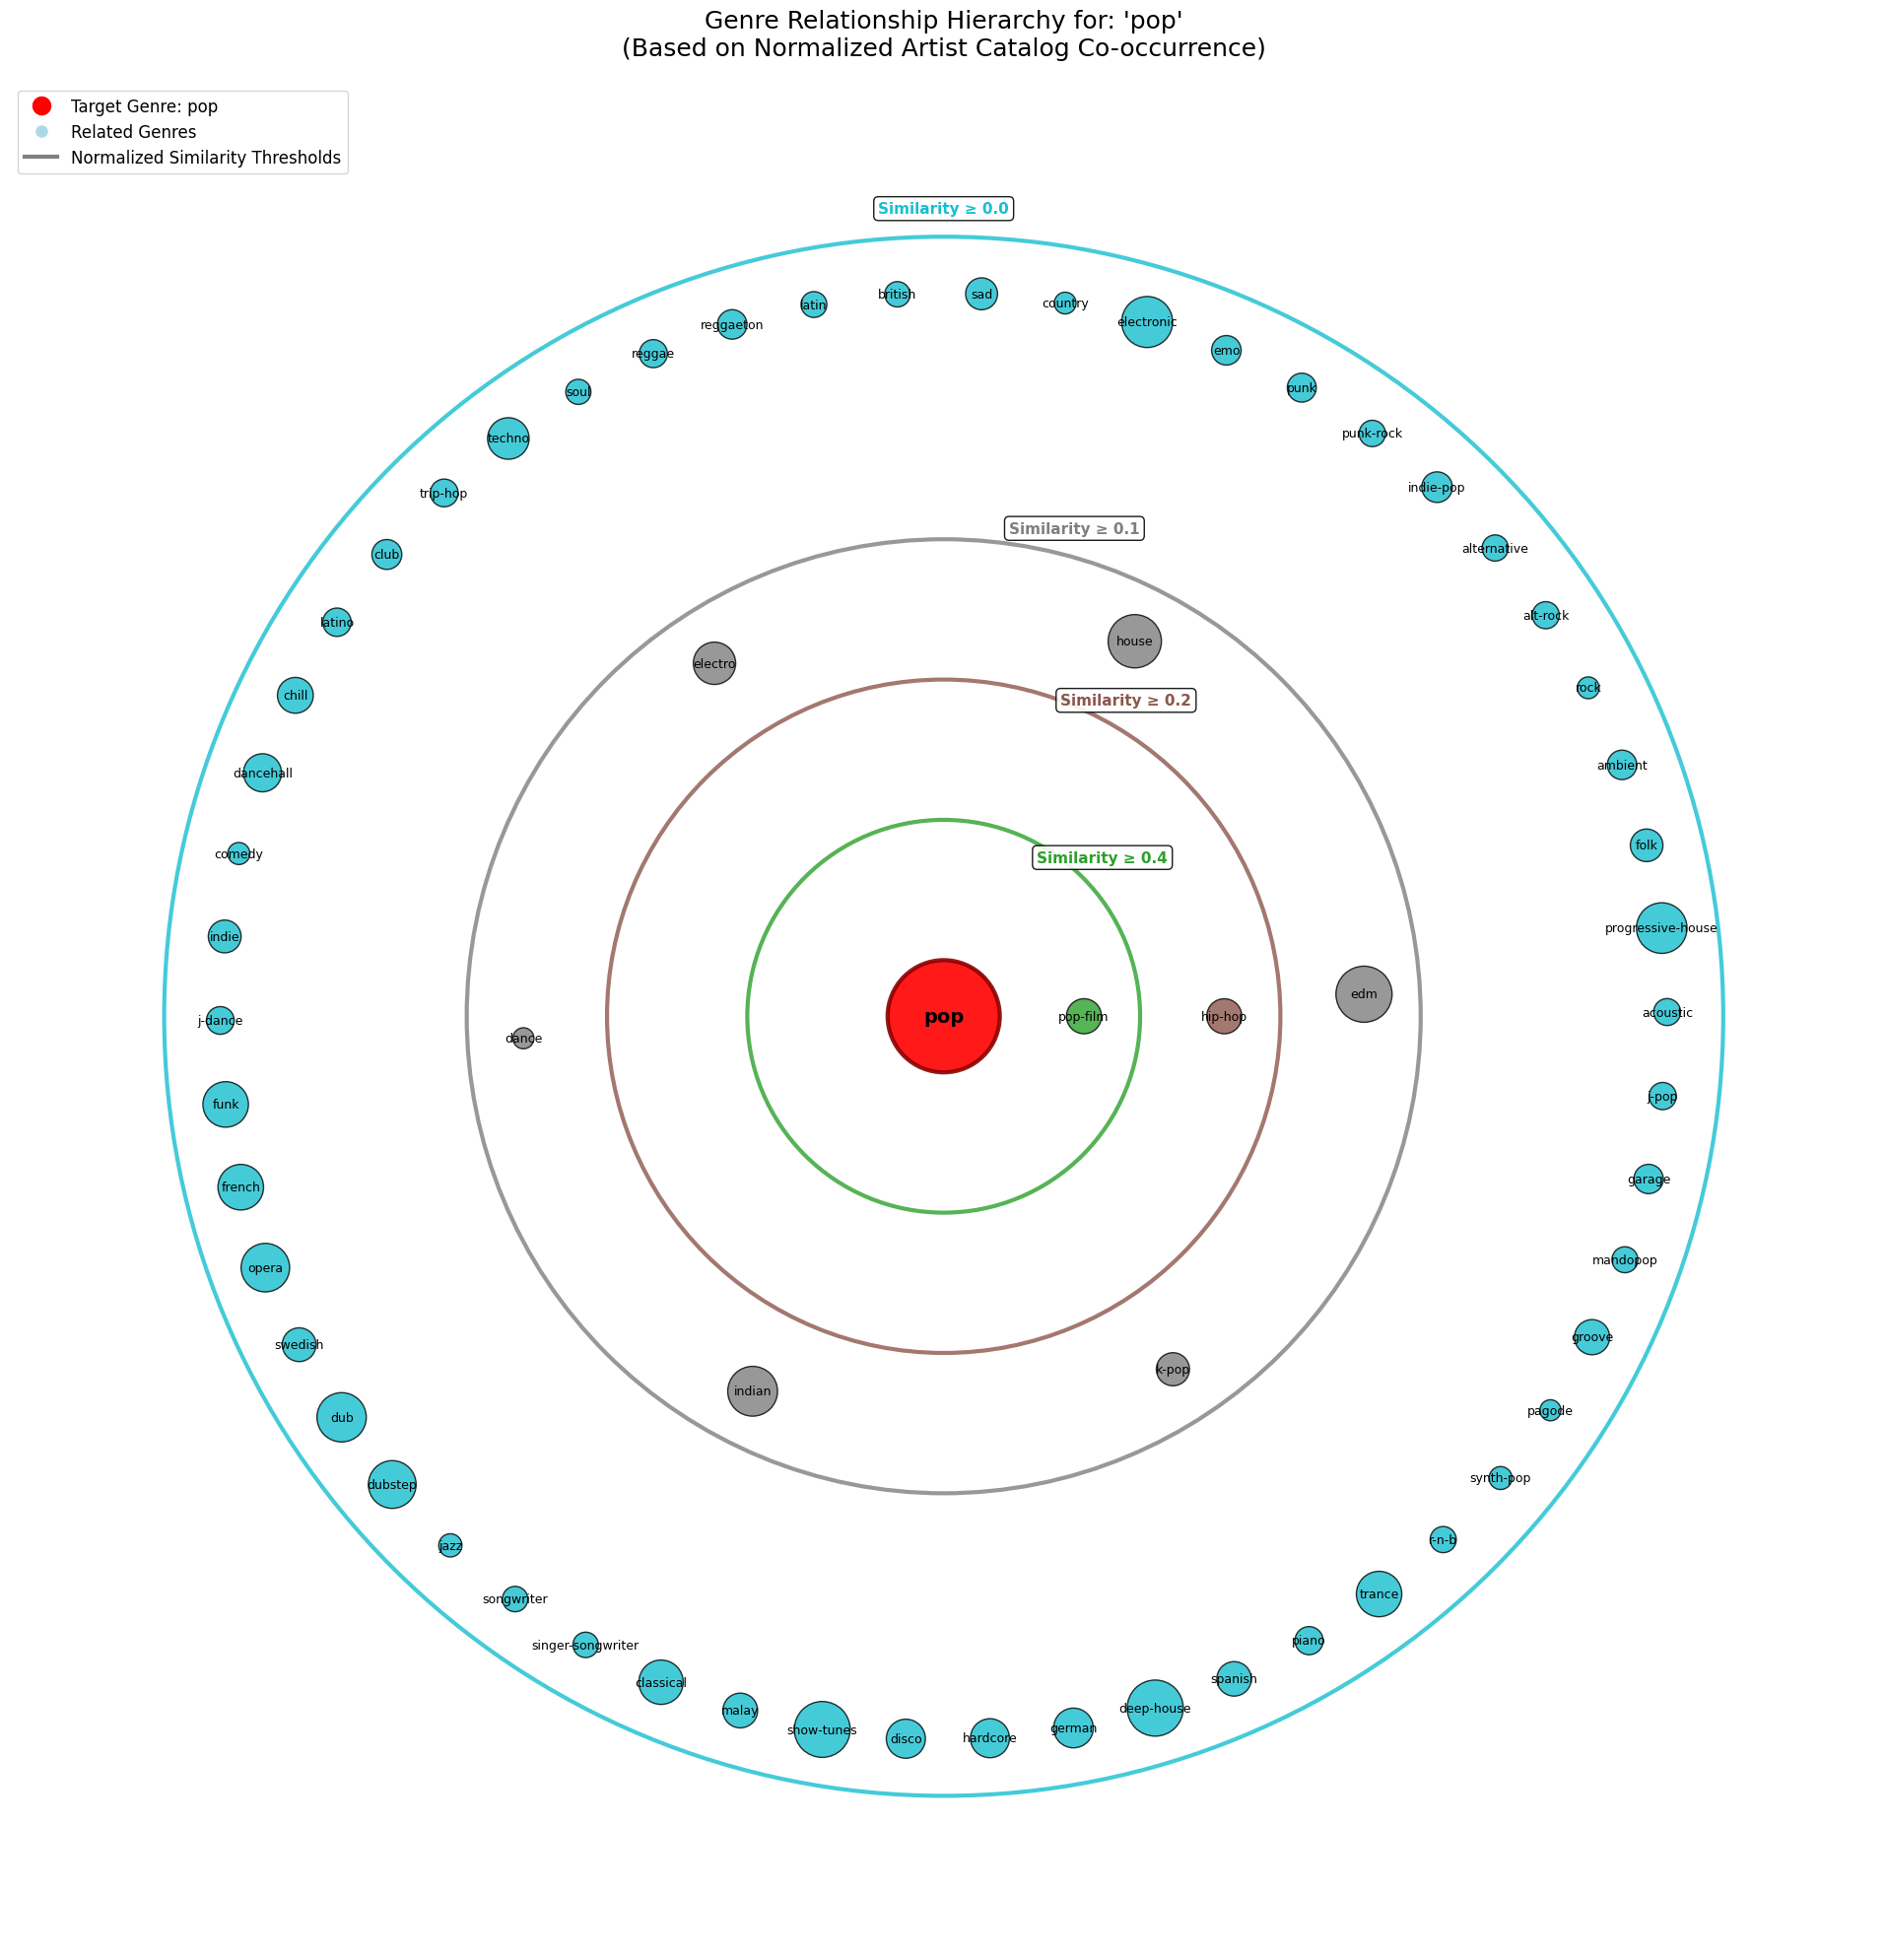

In [47]:
plot_genre_bubble_hierarchy_advanced_networkx('pop', normalized_genre_pairs, genre_counts)

### Basic Insights - Only one Genre

In [9]:
from collections import Counter

# Set to store unique songs
seen_songs = set()
genre_counter = Counter()

# Traverse all edges (even in a multigraph)
for _, _, data in G.edges(data=True):
    song_id = data.get('track_name')
    
    if song_id not in seen_songs:
        seen_songs.add(song_id)
        genre = data.get('genre', 'Unknown')
        genre_counter[genre] += 1

# Get the top 10 genres
top_10_genres = genre_counter.most_common(10)

# Print the results
print("🎵 Top 10 Genres by Unique Songs:")
for i, (genre, count) in enumerate(top_10_genres, 1):
    print(f"{i}. {genre}: {count} songs")

🎵 Top 10 Genres by Unique Songs:
1. black-metal: 969 songs
2. comedy: 962 songs
3. afrobeat: 943 songs
4. heavy-metal: 939 songs
5. cantopop: 935 songs
6. bluegrass: 922 songs
7. malay: 918 songs
8. anime: 918 songs
9. grindcore: 918 songs
10. forro: 915 songs


In [11]:
import networkx as nx
from collections import Counter

# Step 1: Count songs per genre (only once per song)
seen_songs = set()
genre_counter = Counter()

for u, v, data in G.edges(data=True):
    song_id = data.get('track_name')
    if song_id not in seen_songs:
        seen_songs.add(song_id)
        genre = data.get('genre', 'Unknown')
        genre_counter[genre] += 1

top_3_genres = [genre for genre, _ in genre_counter.most_common(3)]
print("🎶 Top 3 genres:", top_3_genres)

# Step 2: Build a filtered list of unique songs per genre
genre_to_edges = {genre: [] for genre in top_3_genres}
seen_by_genre = {genre: set() for genre in top_3_genres}

for u, v, data in G.edges(data=True):
    genre = data.get('genre', 'Unknown')
    track_name = data.get('track_name')
    if genre in top_3_genres and track_name not in seen_by_genre[genre]:
        seen_by_genre[genre].add(track_name)
        genre_to_edges[genre].append((u, v, data))

# Step 3: Build the subgraphs
G_top1 = nx.MultiGraph()
G_top2 = nx.MultiGraph()
G_top3 = nx.MultiGraph()

G_top1.add_edges_from(genre_to_edges[top_3_genres[0]])
G_top2.add_edges_from(genre_to_edges[top_3_genres[1]])
G_top3.add_edges_from(genre_to_edges[top_3_genres[2]])

🎶 Top 3 genres: ['black-metal', 'comedy', 'afrobeat']


[0,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 0,
 0,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 0,
 0,
 0,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 0,
 1,
 0,
 0,
 1,
 2,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 0,
 0,
 0,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,


🎼 Metrics for genre: black-metal
Original MultiGraph — Nodes: 274, Edges: 991
Converted to simple Graph — Nodes: 274, Edges: 273
Average degree: 1.99
Degree distribution (degree: count):
  1: 14
  2: 252
  3: 6
  4: 1
  6: 1
Density: 0.0073
Diameter (largest component): 2
Average shortest path length (largest component): 1.60
Average clustering coefficient: 0.0000


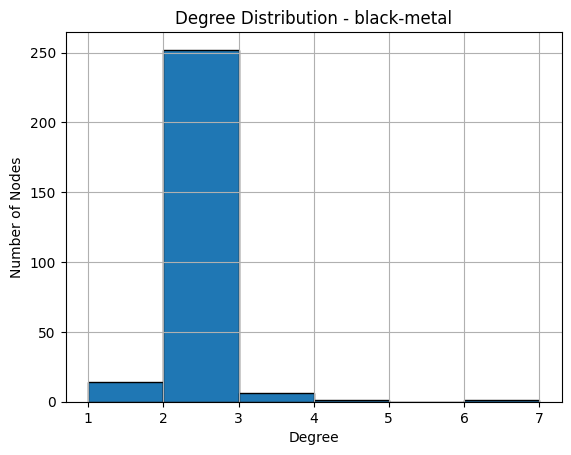


🎼 Metrics for genre: comedy
Original MultiGraph — Nodes: 237, Edges: 990
Converted to simple Graph — Nodes: 237, Edges: 234
Average degree: 1.97
Degree distribution (degree: count):
  1: 35
  2: 189
  3: 9
  4: 1
  6: 1
  8: 1
  10: 1
Density: 0.0084
Diameter (largest component): 4
Average shortest path length (largest component): 2.65
Average clustering coefficient: 0.0000


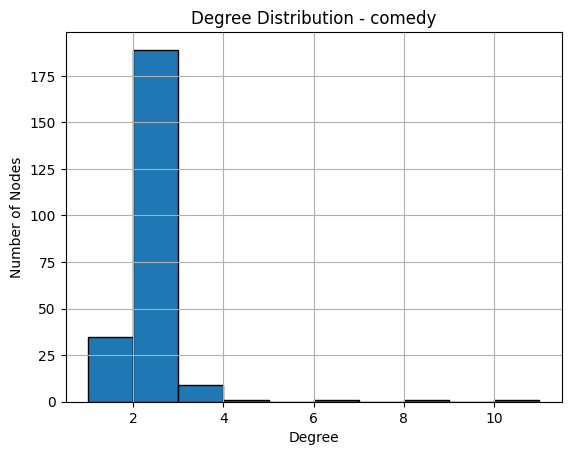


🎼 Metrics for genre: afrobeat
Original MultiGraph — Nodes: 338, Edges: 947
Converted to simple Graph — Nodes: 338, Edges: 327
Average degree: 1.93
Degree distribution (degree: count):
  1: 173
  2: 104
  3: 30
  4: 15
  5: 5
  6: 4
  7: 1
  8: 4
  11: 1
  24: 1
Density: 0.0057
Diameter (largest component): 4
Average shortest path length (largest component): 2.13
Average clustering coefficient: 0.0000


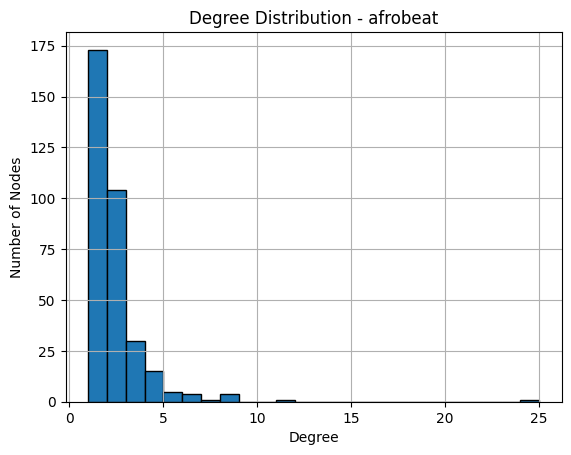

In [13]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def compute_metrics(multigraph, genre_name):
    print(f"\n🎼 Metrics for genre: {genre_name}")
    print(f"Original MultiGraph — Nodes: {multigraph.number_of_nodes()}, Edges: {multigraph.number_of_edges()}")

    # Convert to simple Graph (combine multiple edges)
    graph = nx.Graph()
    for u, v, data in multigraph.edges(data=True):
        if graph.has_edge(u, v):
            # Optionally, you can update weights or aggregate metadata
            continue
        graph.add_edge(u, v, **data)

    print(f"Converted to simple Graph — Nodes: {graph.number_of_nodes()}, Edges: {graph.number_of_edges()}")

    # Degree distribution
    degrees = [deg for _, deg in graph.degree()]
    avg_degree = np.mean(degrees)
    print(f"Average degree: {avg_degree:.2f}")
    
    degree_counts = Counter(degrees)
    print("Degree distribution (degree: count):")
    for deg, count in sorted(degree_counts.items()):
        print(f"  {deg}: {count}")

    # Density
    density = nx.density(graph)
    print(f"Density: {density:.4f}")

    # Largest connected component
    if not nx.is_connected(graph):
        components = list(nx.connected_components(graph))
        largest_cc = max(components, key=len)
        subgraph = graph.subgraph(largest_cc)
    else:
        subgraph = graph

    try:
        diameter = nx.diameter(subgraph)
        avg_path_length = nx.average_shortest_path_length(subgraph)
        print(f"Diameter (largest component): {diameter}")
        print(f"Average shortest path length (largest component): {avg_path_length:.2f}")
    except Exception as e:
        print("⚠️ Could not compute diameter or path length (graph might be too small or disconnected).")

    # Clustering coefficient
    avg_clustering = nx.average_clustering(graph)
    print(f"Average clustering coefficient: {avg_clustering:.4f}")

    # Plot degree distribution
    plt.figure()
    plt.hist(degrees, bins=range(1, max(degrees)+2), edgecolor='black')
    plt.title(f"Degree Distribution - {genre_name}")
    plt.xlabel("Degree")
    plt.ylabel("Number of Nodes")
    plt.grid(True)
    plt.show()

# Compute metrics for top 3 genre graphs
compute_metrics(G_top1, top_3_genres[0])
compute_metrics(G_top2, top_3_genres[1])
compute_metrics(G_top3, top_3_genres[2])

/tmp/ipykernel_56668/3876254975.py:29: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/joaolopes2003/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


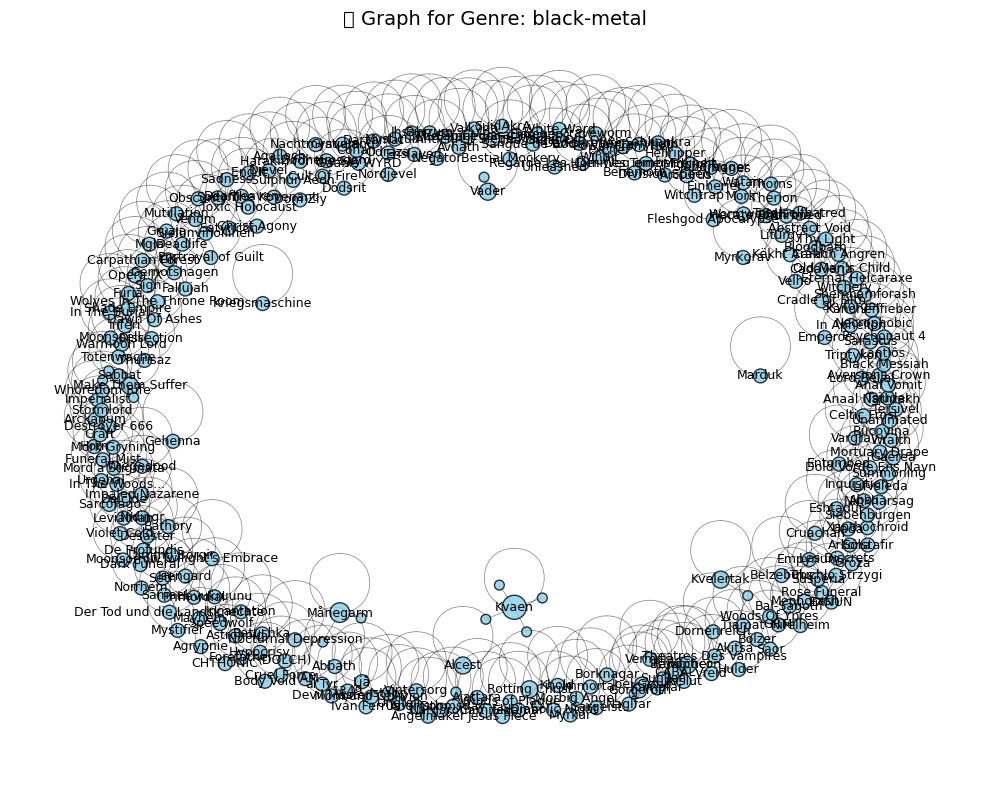

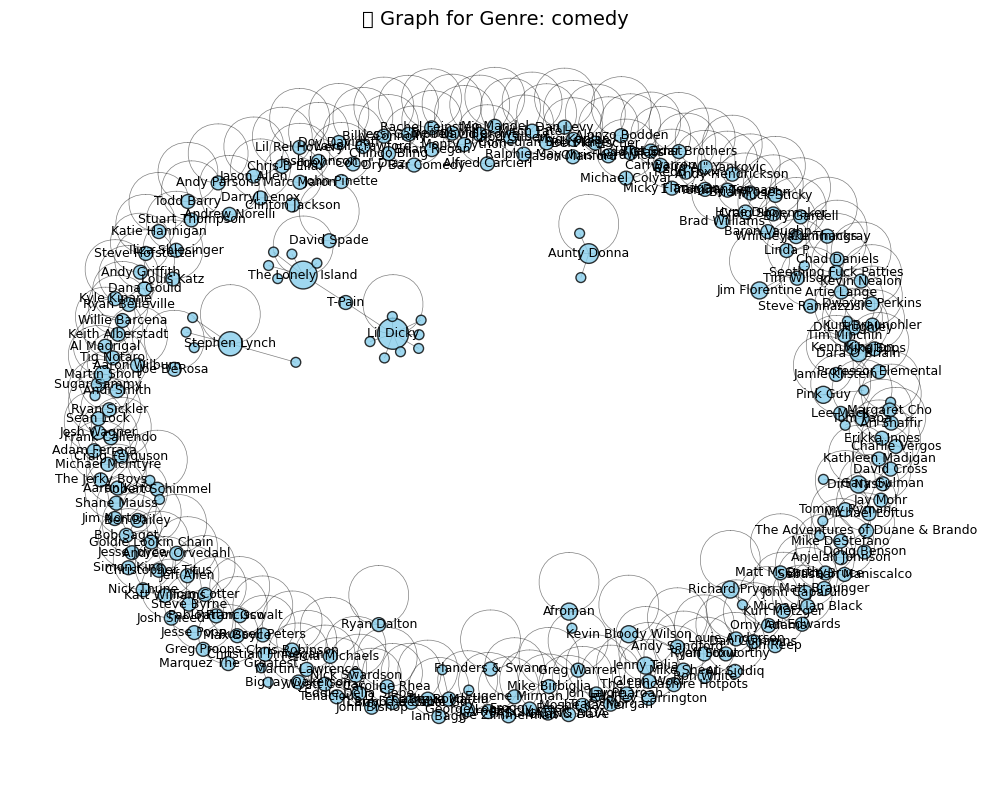

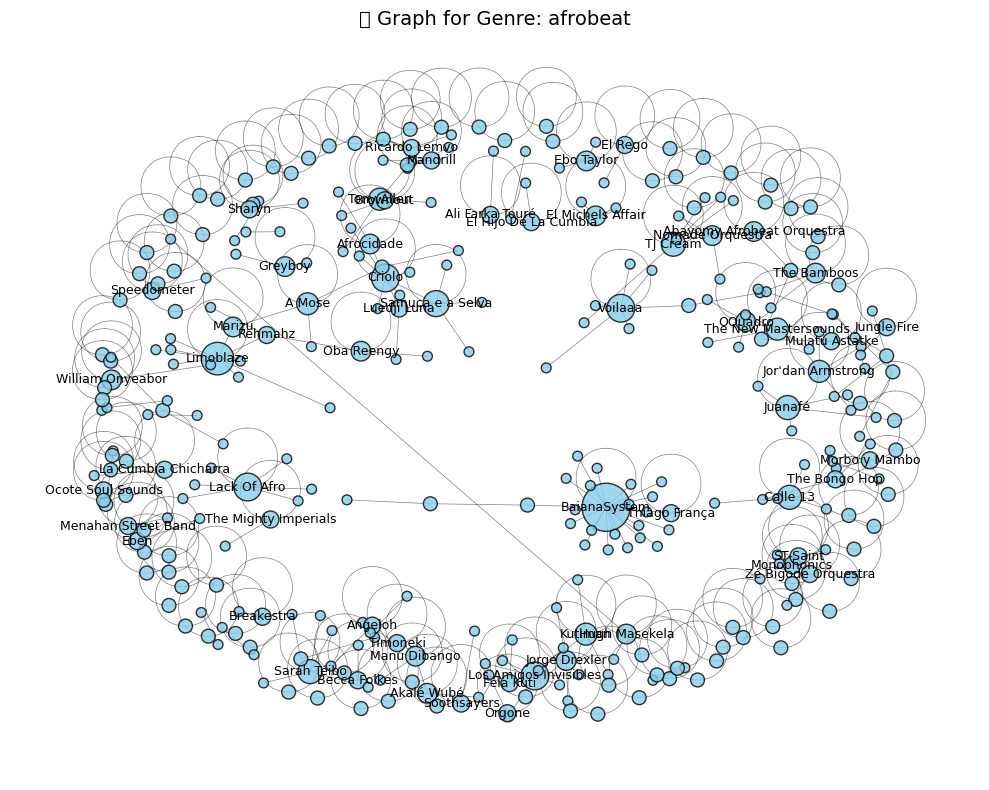

In [14]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_graph(multigraph, genre_name):
    # Convert MultiGraph to Graph (collapse duplicate edges)
    graph = nx.Graph()
    for u, v, data in multigraph.edges(data=True):
        if graph.has_edge(u, v):
            continue  # Ignore repeated songs between same artists
        graph.add_edge(u, v, **data)

    # Use spring layout
    pos = nx.spring_layout(graph, seed=42, k=0.5)

    # Degree-based node sizes
    degrees = dict(graph.degree())
    node_sizes = [degrees[n] * 50 for n in graph.nodes()]  # Scale for visibility

    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(graph, pos, node_size=node_sizes, node_color='skyblue', alpha=0.8, edgecolors='black')
    nx.draw_networkx_edges(graph, pos, width=0.5, alpha=0.5)
    
    # Optional: Add labels only for high-degree nodes
    labels = {n: n for n, d in degrees.items() if d >= np.percentile(list(degrees.values()), 90)}
    nx.draw_networkx_labels(graph, pos, labels, font_size=9)

    plt.title(f"🎵 Graph for Genre: {genre_name}", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot each of the top 3
plot_graph(G_top1, top_3_genres[0])
plot_graph(G_top2, top_3_genres[1])
plot_graph(G_top3, top_3_genres[2])

/tmp/ipykernel_56668/551750983.py:46: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


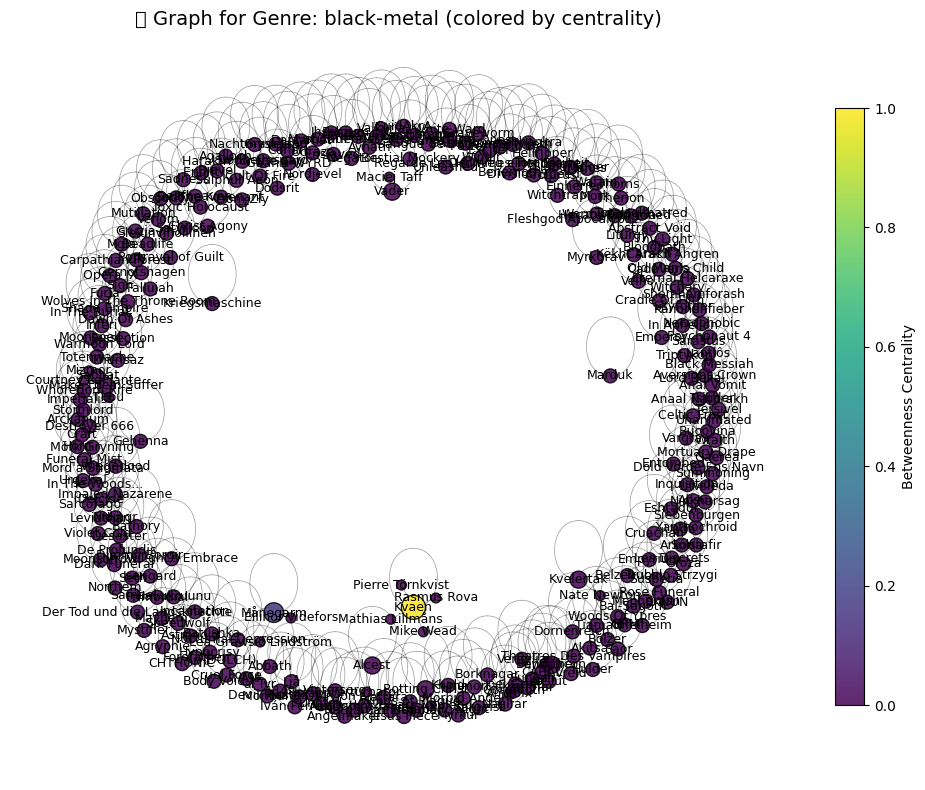

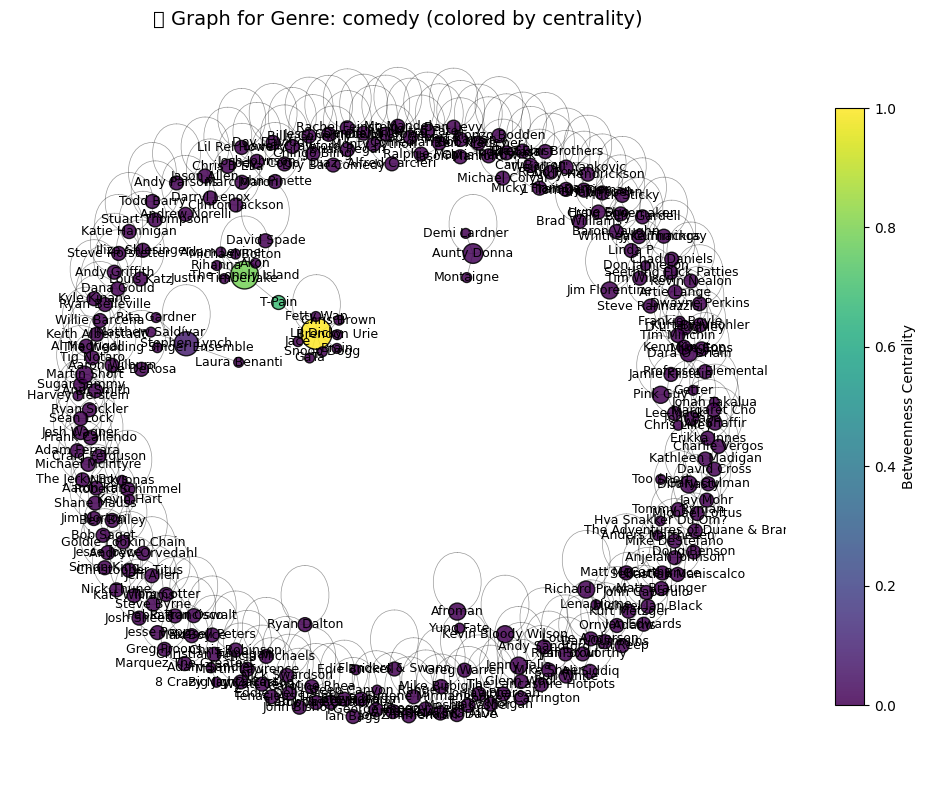

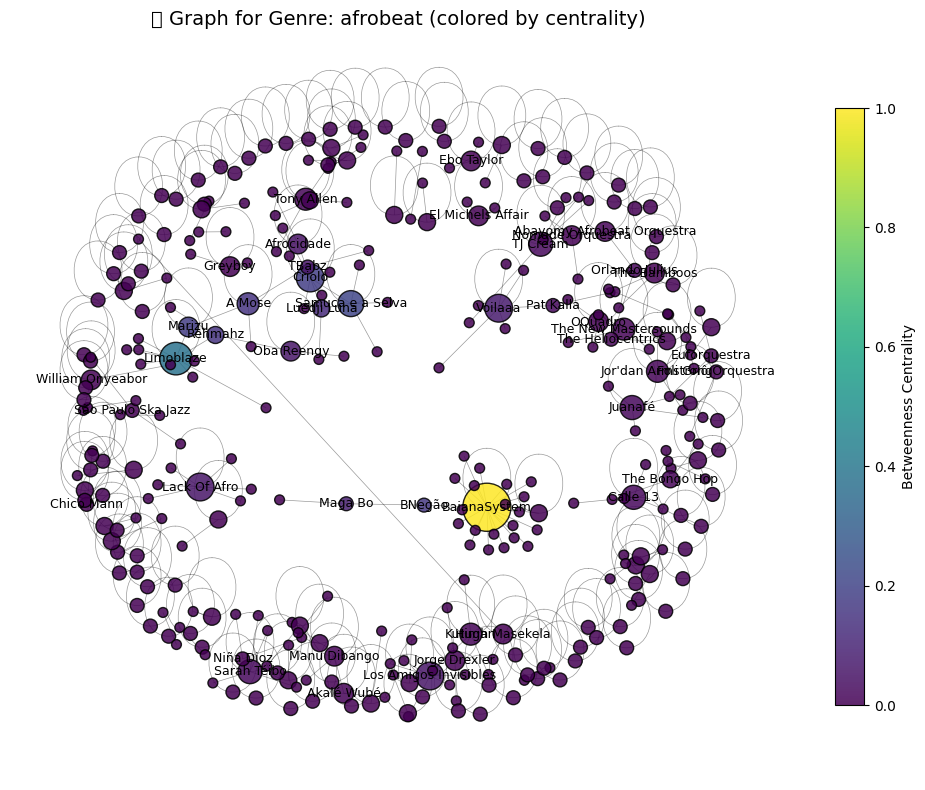

In [15]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def plot_graph_with_centrality(multigraph, genre_name):
    # Convert MultiGraph to Graph (collapse duplicate edges)
    graph = nx.Graph()
    for u, v, data in multigraph.edges(data=True):
        if graph.has_edge(u, v):
            continue  # Skip repeated song edges
        graph.add_edge(u, v, **data)

    # Use spring layout
    pos = nx.spring_layout(graph, seed=42, k=0.5)

    # Degree-based node sizes
    degrees = dict(graph.degree())
    node_sizes = [degrees[n] * 50 for n in graph.nodes()]  # Scale size

    # Centrality for color
    centrality = nx.betweenness_centrality(graph)
    centrality_values = list(centrality.values())
    norm = plt.Normalize(min(centrality_values), max(centrality_values))
    node_colors = [norm(centrality[n]) for n in graph.nodes()]

    plt.figure(figsize=(10, 8))
    nodes = nx.draw_networkx_nodes(
        graph, pos,
        node_size=node_sizes,
        node_color=node_colors,
        cmap=plt.cm.viridis,
        alpha=0.85,
        edgecolors='black'
    )
    nx.draw_networkx_edges(graph, pos, width=0.5, alpha=0.4)

    # Show top 10% most central labels
    threshold = np.percentile(list(centrality.values()), 90)
    labels = {n: n for n, c in centrality.items() if c >= threshold}
    nx.draw_networkx_labels(graph, pos, labels, font_size=9)

    plt.title(f"🎵 Graph for Genre: {genre_name} (colored by centrality)", fontsize=14)
    plt.axis('off')
    cbar = plt.colorbar(nodes, shrink=0.8)
    cbar.set_label('Betweenness Centrality')
    plt.tight_layout()
    plt.show()

# Plot top 3 genres with centrality-based coloring
plot_graph_with_centrality(G_top1, top_3_genres[0])
plot_graph_with_centrality(G_top2, top_3_genres[1])
plot_graph_with_centrality(G_top3, top_3_genres[2])

### Advanced Features

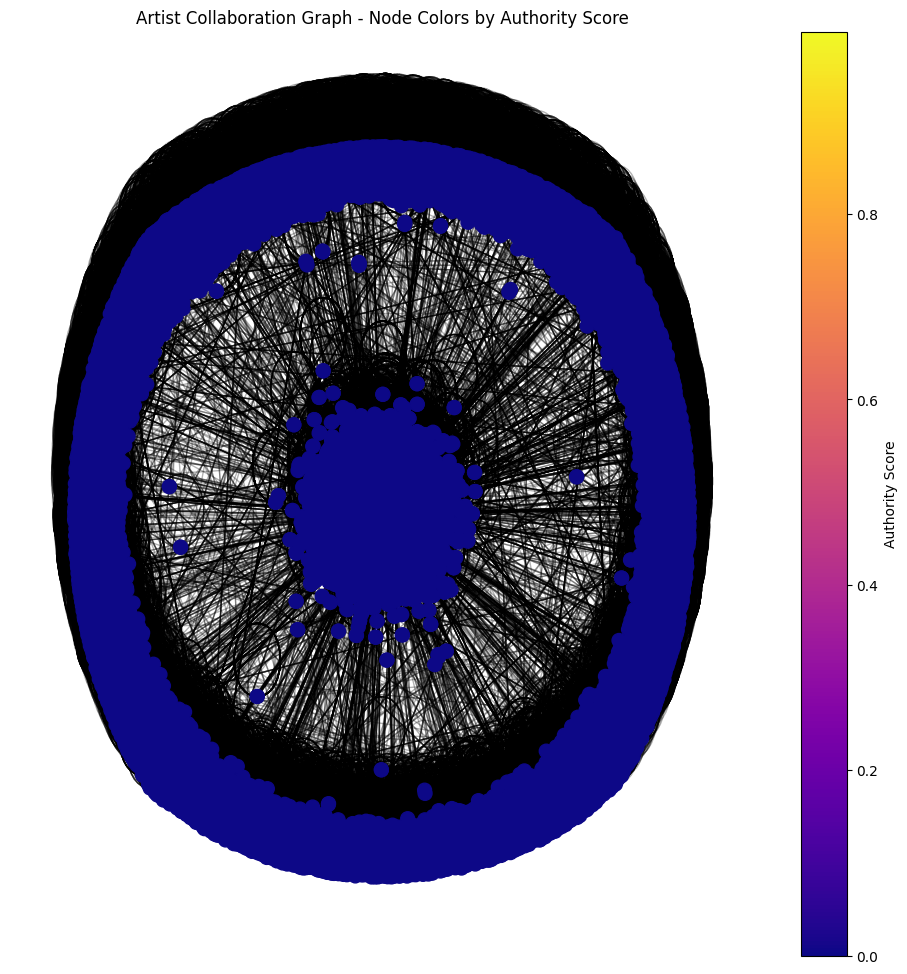

In [19]:
import networkx as nx
import matplotlib.pyplot as plt

# Run HITS algorithm
hits_hubs, hits_authorities = nx.hits(G, max_iter=1000, normalized=True)

# Add authority score as node attribute for visualization
nx.set_node_attributes(G, hits_authorities, 'authority')

# Visualize graph with node color mapped to authority scores
plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G, seed=42)  # layout for node positioning

# Node colors based on authority scores (normalized 0-1)
node_colors = [hits_authorities[node] for node in G.nodes()]

nodes = nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.plasma, node_size=100)
edges = nx.draw_networkx_edges(G, pos, alpha=0.3)

plt.colorbar(nodes, label='Authority Score')
plt.title('Artist Collaboration Graph - Node Colors by Authority Score')
plt.axis('off')
plt.show()


In [20]:
import community as community_louvain

# Convert to simple graph for community detection (MultiGraph → Graph)
G_simple = nx.Graph()
for u, v, data in G.edges(data=True):
    w = data.get('weight', 1)
    if G_simple.has_edge(u, v):
        G_simple[u][v]['weight'] += w
    else:
        G_simple.add_edge(u, v, weight=w)

# Detect communities
partition = community_louvain.best_partition(G_simple, weight='weight')

# Count number of communities
import collections
community_sizes = collections.Counter(partition.values())
print(f"Detected {len(community_sizes)} communities")

Detected 13662 communities
